In [2]:
# import tictactics_bitlogic as tact
import tictactics_cython as tact
import numpy as np
import itertools
import matplotlib
import cProfile
from matplotlib import pyplot as plt
%matplotlib inline
Board = tact.Board

import numpy as np
import sys
import itertools

BITS = np.array([[1<<0,1<<1,1<<2],[1<<4,1<<5,1<<6],[1<<8,1<<9,1<<10]])

class Board(object):
    """The board will be a numpy 3x3 numpy array when being used with this class"""
    
    def __init__(self,board = 'None',active_board = (1,1),big_board = 'None',player = 1):
        self.player = player
        self.log = []
        self.alog = [active_board]
        self.over = False
        self.result = 0
        
        self.active_board = active_board
        
        if board == 'None':
            board = np.zeros((9,9))
            self.board = np.copy(board)
        else:
            self.board = np.copy(board)

        if big_board == 'None':
            big_board = np.zeros((3,3))
            self.big_board = big_board
        else:
            self.big_board = big_board
            
        
            

    def update_move(self,move):
        assert(move in self.legal_moves())
        active_board = (move[0]/3,move[1]/3)
#         assert(active_board == self.active_board)
        self.board[move] = self.player
        self.player *= -1
        if self.big_board[active_board]==0:
            self.big_board[active_board] = check_board_win(self.small_board(active_board))
            if self.big_board[active_board]:
                self.result = check_board_win(self.big_board)
                if self.result:
                    self.over = True
                
            
        
        self.active_board = (move[0]%3,move[1]%3)
        self.log.append(move)
        self.alog.append(self.active_board)
        return None
    

        
    def erase_move(self):
        move = self.log.pop()
        active_board = (move[0]/3,move[1]/3)
        self.alog.pop()
        self.board[move] = 0
        self.player *= -1
        
        active_board_board = self.small_board(active_board)
        
        if check_board_win(active_board_board):
            None
        else:
            self.big_board[active_board] = 0
            
        self.active_board = self.alog[-1]
        self.over = False
        self.result = 0
            
        return None
    
    def is_full(self):
        return np.prod(self.board)
    
    def game_over(self):
        self.over = bool(self.winner() or np.prod(self.board))
        return self.over
    
    def legal_moves(self):
        if self.over:
            return []
#         board = self.small_board(self.active_board)
        if self.active_board == 'None':
            return [move for move in itertools.product(range(9),range(9)) if self.board[move] == 0]
        board_moves = itertools.product(range(self.active_board[0]*3,self.active_board[0]*3+3) , 
                                      range(self.active_board[1]*3,self.active_board[1]*3+3))
        move_list = [move for move in board_moves if self.board[move] == 0]
        
        if len(self.log)>0 and len(move_list) > 1:
            last_active = (self.log[-1][0]/3,self.log[-1][1]/3)
            illegal_move = (self.active_board[0]*3 + last_active[0],self.active_board[1]*3 + last_active[1])
            if illegal_move in move_list:
                move_list.remove(illegal_move)
                
        if len(move_list) == 0:
            move_list = [move for move in itertools.product(range(9),range(9)) if self.board[move] == 0]
            
        return move_list
                
            
        
        
    def small_board(self,location):
        return self.board[location[0]*3:location[0]*3+3,location[1]*3:location[1]*3+3]
    
def check_board_win(board):
#     #check player 1 win
#     dummy = np.copy(board)
#     dummy = np.sign(dummy)
#     p1_win = 0
#     p2_win = 0
    
#     if np.any(np.sum(dummy,axis=0)==3):
#         p1_win = 1
#     elif np.any(np.sum(dummy,axis=1)==3):
#         p1_win = 1
#     elif dummy[0,0]+dummy[1,1]+dummy[2,2]==3:
#         p1_win = 1
#     elif dummy[0,2]+dummy[1,1]+dummy[2,0]==3:
#         p1_win = 1
        
#     #check player 2 win
#     dummy = np.copy(board)
#     dummy = (((dummy == -1).astype(int) + (dummy == 2).astype(int)) == 1).astype(int)
    
#     if np.any(np.sum(dummy,axis=0)==3):
#         p2_win = 1
#     elif np.any(np.sum(dummy,axis=1)==3):
#         p2_win = 1
#     elif dummy[0,0]+dummy[1,1]+dummy[2,2]==3:
#         p2_win = 1
#     elif dummy[0,2]+dummy[1,1]+dummy[2,0]==3:
#         p2_win = 1   
        
# try some bit logic
    '''
      0  1  2
      4  5  6
      8  9 10

      bitboard with missing right to prevent wraparound during bit shifting

    '''

    p1_win = False
    p2_win = False
#     check player 1 win
    dummy = ((board == 1) + (board == 2)).astype(int)
    bit = long(np.sum(dummy*BITS))
    if ((bit & bit<<1 & bit<<2) |  # - horizontal
    (bit & bit<<3 & bit<<6) | # / diagonal
    (bit & bit<<4 & bit<<8) | # | vertical
    (bit & bit<<5 & bit<<10)):  # \ diagonal
        p1_win = True
    
    #check player 2 win
    dummy= (((board == -1).astype(int) + (board == 2).astype(int)) == 1).astype(int)
    bit = long(np.sum(dummy*BITS))
    if ((bit & bit<<1 & bit<<2) |  # - horizontal
    (bit & bit<<3 & bit<<6) | # / diagonal
    (bit & bit<<4 & bit<<8) | # | vertical
    (bit & bit<<5 & bit<<10)):  # \ diagonal
        p2_win = True
        
        
        
        
#     legend
#      2: board over, no win
#      1: player 1 wins
#      0: undecided
#     -1: player 2 wins
#     -2: draw (both players win)
        
    if p1_win and p2_win:
        return -2
    if p1_win:
        return 1
    if p2_win:
        return -1
    
    if np.prod(board):
        return 2
    return 0

import tictactics_bitlogic as tact
Board = tact.Board

In [3]:
import random
import time
from IPython import display
import weakref

class MC_node():
    def __init__(self,game):
#         self.actions = game.legal_moves()
        self.player = 1 if game.player==0 else -1
#         self.player = game.player
        self.name = ''.join(map(str,game.log))
        

        #proof numbers
        if game.over:
            self.solved = True
            
            if game.result == 1:
                self.GW = 0
                self.GT = 0
                self.ST = np.inf
                self.SL = np.inf
            elif game.result == -1:
                self.GW = np.inf
                self.GT = np.inf
                self.ST = 0
                self.SL = 0
            else:
                self.GW = np.inf
                self.GT = 0
                self.ST = 0
                self.SL = np.inf     
            self.min_depth=0
            self.max_depth=0
        else:
            self.solved = False
            
            self.GW = 1
            self.GT = 1
            self.ST = 1
            self.SL = 1
        
            self.min_depth = 1
            self.max_depth = 1
        self.leaf = True
        self.children = {}
        self.parent = None
#         self.key = board_to_cache(game)
        self.key = game.key
        
    def __repr__(self):
        return self.name
#         return 'key: {}\nactions: {}\nGW: {}\nGT: {}\nST: {}\nSL: {}'.format(self.key,self.actions,self.GW,self.GT,self.ST,self.SL)


def PN_select(node,game,cache = None):

    
    while not node.leaf:
        
        if cache is not None:
            if node.key in cache:
                clone = cache[node.key]
                if clone.GW ==node.GW and clone.GT==node.GT and clone.ST==node.ST and clone.SL==node.SL:
#                 if not clone.solved:
                    None
                else:
                    clone_node(clone,node)
                    if node.parent is not None:
                        if 'transpositions' in cache:
                            cache['transpositions']+=1
                        else:
                            cache['transpositions'] = 1
                        return node.parent()
                    else:
                        sys.exit('no parent???')
        try:
            unsolved = [move for move in node.actions if not node.children[move].solved]
        except Exception as e:
            print node.actions
            print node.children
            print node.solved
            node.leaf
#             print game.board
            print str(e)
            print 'failed to make unsolved list'
            print game.log
            print game.print_board()
            print game.bit1
            print game.bit2
            sys.exit()
#         unsolved = [move for move in node.actions if node.children[move].GW !=0 and node.children[move].SL != 0 and 
#                    (node.children[move].GT != 0 or node.children[move].ST != 0)]
        if len(unsolved) ==0 and all([child.solved and child.min_depth == child.max_depth for child in node.children.values()]):
            print node.min_depth,node.max_depth
            print game.print_board()
            print node.solved
            for move in node.actions:
                print move , node.children[move].GW, node.children[move].SL,node.children[move].GT,node.children[move].ST
                print node.children[move].min_depth,node.children[move].max_depth
            sys.exit('all moves solved')
#         unsolved = node.actions

        #try to find shortest depth
#         try:
        if node.solved:
            if node.player == 1:
                if node.GW == 0:
                    viable = [move for move in node.actions if not node.children[move].solved or node.children[move].GW==0 and
                      node.children[move].max_depth != node.children[move].min_depth]
                    move = min([(node.children[move].min_depth , move) for move in viable])[-1]
                elif node.GT == 0:
                    viable = [move for move in node.actions if not node.children[move].solved or node.children[move].GT==0 and
                      node.children[move].max_depth != node.children[move].min_depth]
                    move = min([(node.children[move].min_depth , move) for move in viable])[-1]
                else:
                    viable = [move for move in node.actions if
                      node.children[move].max_depth != node.children[move].min_depth]
                    move = max([(node.children[move].max_depth , move) for move in viable])[-1]

            if node.player == -1:
                if node.SL == 0:
                    viable = [move for move in node.actions if not node.children[move].solved or node.children[move].SL==0 and
                      node.children[move].max_depth != node.children[move].min_depth]
                    move = min([(node.children[move].min_depth , move) for move in viable])[-1]
                elif node.ST == 0:
                    viable = [move for move in node.actions if not node.children[move].solved or node.children[move].ST==0 and
                      node.children[move].max_depth != node.children[move].min_depth]
                    move = min([(node.children[move].min_depth , move) for move in viable])[-1]
                else:
                    viable = [move for move in node.actions if
                      node.children[move].max_depth != node.children[move].min_depth]
                    move = max([(node.children[move].max_depth , move) for move in viable])[-1]

#             assert(not node.children[move].solved or node.children[move].max_depth != node.children[move].min_depth)
#         unsolved = node.actions
        elif node.player == 1:
            move = min([(node.children[move].GT,node.children[move].GW,move) for move in unsolved])[-1]
        elif node.player == -1:
            move = min([(node.children[move].ST,node.children[move].SL,move) for move in unsolved])[-1]

#         except Exception as e:
#     #             print str(e)
#     #             print node.GW,node.GT,node.ST,node.SL
#     #             print node.min_depth,node.max_depth
#     #             print node.player
#     #             print node.actions
#     #             for child in node.children.values():
#     #                 print child.GW,child.GT,child.ST,child.SL
#     #                 print child.min_depth
#     #                 print child.max_depth
#     #             sys.exit()
#             viable = [move for move in node.actions if node.children[move].max_depth != node.children[move].min_depth]
#             move = min([(node.children[move].min_depth,move) for move in viable])[-1]
        try:
            game.update_move(move)
        except:
            print move
            print game.print_board()
            print game.log
            print unsolved
            print node.actions
            sys.exit('move not accepted')
        node.N[move] +=1
        node = node.children[move]
    return node

def PDN_select(node,game):
    moves = []
    while not node.leaf:

        move = min([(node.children[move].GW,move) for move in node.actions if node.children[move].GW != 0] +
                   [(node.children[move].GT,move) for move in node.actions if node.children[move].GT != 0] + 
                   [(node.children[move].ST,move) for move in node.actions if node.children[move].ST != 0] +
                   [(node.children[move].SL,move) for move in node.actions if node.children[move].SL != 0])[-1]
        node = node.children[move]
        game.update_move(move)
        moves.append(move)
    return node,moves

        
def select(node,game,puct_constant = 1): 
    
    
    # puct algorithm
    moves = []
    
    while not node.leaf and not node.solved:
        actions = [move for move in node.actions if not node.children[move].solved]
#         if node.player == 1:
#             actions = [move for move in node.actions if node.children[move].SL > 0]
#         if node.player == -1:
#             actions = [move for move in node.actions if node.children[move].GW > 0]
        if len(actions) == 0:
            return node,moves
            
        q = node.player * np.array([node.Q[move] for move in actions])
        u = puct_constant * np.sqrt(np.sum(node.N.values())+1) / (
                            1 + np.array([node.N[move] for move in actions]))

        index = np.argmax(q+u)
        move = actions[index]
        node = node.children[move]
        game.update_move(move)
        moves.append(move)
        
    return node , moves
    
    
def evaluate(node,game,depth = 0):
    #MC rollout, maybe a short PN search
    if game.over:
        if game.result == 1:
            node.GW = 0
            node.GT = 0
            node.ST = np.inf
            node.SL = np.inf
        elif game.result == -1:
            node.GW = np.inf
            node.GT = np.inf
            node.ST = 0
            node.SL = 0
        elif abs(game.result) == 2:
            node.GW = np.inf
            node.GT = 0
            node.ST = 0
            node.SL = np.inf   
        else:
#             print game.boardMC
            sys.exit('impossible situation')
    else:
        while not game.over:
            if depth == 0:
                move = random.choice(game.legal_moves())
                game.update_move(move)
            else:
                move = simple_minimax(game,depth = depth)[0]
                game.update_move(move)
                
        
    if game.result == 1:
        result = 1
    elif game.result == -1:
        result = -1
    else:
        result = 0
    return result
    
def PN_backprop(node,prune = False,depth = False,cache = None):
    
    #MC backprop, maybe PN backprop
    while True:

        children = node.children.values()
        if not node.leaf and not node.solved:

            #PN stuff
            if node.player == 1:
                node.GW = min([child.GW for child in children])
                node.GT = min([child.GT for child in children])
                node.ST = sum([child.ST for child in children])
                node.SL = sum([child.SL for child in children])

            if node.player == -1:
                node.SL = min([child.SL for child in children])
                node.ST = min([child.ST for child in children])
                node.GT = sum([child.GT for child in children])
                node.GW = sum([child.GW for child in children])

            if node.GW == 0 or node.SL == 0 or (node.GT == 0 and node.ST == 0):
                node.solved = True
            if prune and node.solved and node.parent is not None:
                prune_tree(node)
            if depth:
                # depth finding is kind funny. Players try to win asap and lose as long as possible.
                if node.solved:
                    if node.player == 1:
                        if node.GW == 0:
                            node.max_depth = min([child.max_depth for child in children if child.GW == 0])+1
                            node.min_depth = min([child.min_depth for child in children if child.GW <np.inf])+1
                        elif node.GW < np.inf:
                            node.max_depth = max([child.max_depth for child in children if child.GW < np.inf])+1
                            node.min_depth = min([child.min_depth for child in children if child.GW < np.inf])+1
                        else:
                            if node.GT == 0:
                                node.max_depth = min([child.max_depth for child in children if child.GT == 0])+1
                                node.min_depth = min([child.max_depth for child in children if child.GT < np.inf])+1
                            elif node.GT < np.inf:
                                node.max_depth = max([child.max_depth for child in children if child.GT < np.inf])+1
                                node.min_depth = min([child.min_depth for child in children if child.GT < np.inf])+1
                            else:
                                node.max_depth = max([child.max_depth for child in children])+1
                                node.min_depth = max([child.min_depth for child in children])+1
                    if node.player == - 1:
                        if node.SL == 0:
                            node.max_depth = min([child.max_depth for child in children if child.SL == 0])+1
                            node.min_depth = min([child.min_depth for child in children if child.SL <np.inf])+1
                        elif node.SL < np.inf:
                            node.max_depth = max([child.max_depth for child in children if child.SL < np.inf])+1
                            node.min_depth = min([child.min_depth for child in children if child.SL < np.inf])+1
                        else:
                            if node.ST == 0:
                                node.max_depth = min([child.max_depth for child in children if child.ST == 0])+1
                                node.min_depth = min([child.max_depth for child in children if child.ST < np.inf])+1
                            elif node.ST < np.inf:
                                node.max_depth = max([child.max_depth for child in children if child.ST < np.inf])+1
                                node.min_depth = min([child.min_depth for child in children if child.ST < np.inf])+1
                            else:
                                node.max_depth = max([child.max_depth for child in children])+1
                                node.min_depth = max([child.min_depth for child in children])+1

        #             node.max_depth = min([child.max_depth for child in children if child.GW == node.GW
        #                                  and child.GT == node.GT and child.ST == node.ST and child.SL == node.SL]) + 1
        #             node.min_depth = min([child.min_depth for child in children if not ch|ild.solved or (child.GW == node.GW
        #                                  and child.GT == node.GT and child.ST == node.ST and child.SL == node.SL)]) + 1
                else:
                    node.max_depth = max([child.max_depth for child in children if not child.solved]) + 1
                    node.min_depth = min([child.min_depth for child in children if not child.solved]) + 1


#         for clone in node.same:
#             backprop(clone,[-1],0,mode = 'ignore MC')

        # MC stuff
        if cache is not None:
            cache[node.key] = node
        if node.parent is None:
            break
        node = node.parent()
            
    None
    
    
    
    
def backprop(node, moves, result , prune = False,mode = None):
    #MC backprop, maybe PN backprop

    while True:

        children = node.children.values()
        if not node.leaf and not node.solved:

            #PN stuff
            if node.player == 1:
                node.GW = min([child.GW for child in children])
                node.GT = min([child.GT for child in children])
                node.ST = sum([child.ST for child in children])
                node.SL = sum([child.SL for child in children])

            if node.player == -1:
                node.SL = min([child.SL for child in children])
                node.ST = min([child.ST for child in children])
                node.GT = sum([child.GT for child in children])
                node.GW = sum([child.GW for child in children])

            if node.GW == 0 or node.SL == 0 or (node.GT == 0 and node.ST == 0):
                node.solved = True
            if prune and node.solved and node.parent is not None:
                prune_tree(node)
            if mode == 'depth':
                # depth finding is kind funny. Players try to win asap and lose as long as possible.
                if node.solved:
                    if node.player == 1:
                        if node.GW == 0:
                            node.max_depth = min([child.max_depth for child in children if child.GW == 0])+1
                            node.min_depth = min([child.min_depth for child in children if child.GW <np.inf])+1
                        elif node.GW < np.inf:
                            node.max_depth = max([child.max_depth for child in children if child.GW < np.inf])+1
                            node.min_depth = min([child.min_depth for child in children if child.GW < np.inf])+1
                        else:
                            if node.GT == 0:
                                node.max_depth = min([child.max_depth for child in children if child.GT == 0])+1
                                node.min_depth = min([child.max_depth for child in children if child.GT < np.inf])+1
                            elif node.GT < np.inf:
                                node.max_depth = max([child.max_depth for child in children if child.GT < np.inf])+1
                                node.min_depth = min([child.min_depth for child in children if child.GT < np.inf])+1
                            else:
                                node.max_depth = max([child.max_depth for child in children])+1
                                node.min_depth = max([child.min_depth for child in children])+1
                    if node.player == - 1:
                        if node.SL == 0:
                            node.max_depth = min([child.max_depth for child in children if child.SL == 0])+1
                            node.min_depth = min([child.min_depth for child in children if child.SL <np.inf])+1
                        elif node.SL < np.inf:
                            node.max_depth = max([child.max_depth for child in children if child.SL < np.inf])+1
                            node.min_depth = min([child.min_depth for child in children if child.SL < np.inf])+1
                        else:
                            if node.ST == 0:
                                node.max_depth = min([child.max_depth for child in children if child.ST == 0])+1
                                node.min_depth = min([child.max_depth for child in children if child.ST < np.inf])+1
                            elif node.ST < np.inf:
                                node.max_depth = max([child.max_depth for child in children if child.ST < np.inf])+1
                                node.min_depth = min([child.min_depth for child in children if child.ST < np.inf])+1
                            else:
                                node.max_depth = max([child.max_depth for child in children])+1
                                node.min_depth = max([child.min_depth for child in children])+1

        #             node.max_depth = min([child.max_depth for child in children if child.GW == node.GW
        #                                  and child.GT == node.GT and child.ST == node.ST and child.SL == node.SL]) + 1
        #             node.min_depth = min([child.min_depth for child in children if not ch|ild.solved or (child.GW == node.GW
        #                                  and child.GT == node.GT and child.ST == node.ST and child.SL == node.SL)]) + 1
                else:
                    node.max_depth = max([child.max_depth for child in children if not child.solved]) + 1
                    node.min_depth = min([child.min_depth for child in children if not child.solved]) + 1


#         for clone in node.same:
#             backprop(clone,[-1],0,mode = 'ignore MC')
        if node.parent is None:
            break
        # MC stuff
        
        node = node.parent()
        
        if mode != 'ignore MC':
            move = moves.pop()
            node.N[move]+=1
            node.V[move]+=result   
            node.Q[move]=float((node.V[move]))/node.N[move]
        
            
    None
    
def board_to_cache(game):
    board = list(game.board.reshape(-1))
    d = {-1:'O',0:'_',1:'X'}
    return ''.join(map(lambda x: d[x],board))
    
    

def expand(node,game,cache = None):
    # Add Children to tree
#     for move in game.legal_moves():
    node.actions = game.legal_moves()
    node.N = {move:0 for move in node.actions}
    node.V = {move:0 for move in node.actions}
    node.Q = {move:0 for move in node.actions}
    for move in node.actions:
        game.update_move(move)
        child = MC_node(game)
        if cache is not None:
            cache[board_to_cache(game)] = child
        node.children[move] = child
        child.parent = weakref.ref(node)
#         child.parent = node
        game.erase_move()
    node.leaf = len(node.children) == 0
        
    None
        
        
def mc_pass(root,game):
#     node,moves = select(root,game,puct_constant = 5)
    node,moves = PN_select(root,game)
#     node,moves = PDN_select(root,game)
    expand(node,game)
    result = evaluate(node,game)
#     result = 0
    backprop(node,moves,result)
    
def clone_node(node1,node2):
    node2.GT=node1.GT
    node2.GW=node1.GW
    node2.SL=node1.SL
    node2.ST=node1.ST
#     node2.leaf=node1.leaf
    node2.max_depth=node1.max_depth
    node2.min_depth=node1.min_depth
    node2.solved = node1.solved
    node2.key=node1.key
#     if node1.parent is not None and node2.parent is not None:
#         clone_node(node1.parent(),node2.parent())
    
def print_MC(node):
    if not node.children:
        return
    for move in sorted(node.actions,key = lambda x: - node.N[x]):
        print '{}: {:9d} runs, {:+0.4f} eval, {:4g} won, {:4g} not lost, {:4g} not won, {:4g} lost, {:2g}-{:2g} depth'.format(
            move,
            node.N[move],
            0. if node.N[move] == 0 else float(node.V[move]) / node.N[move],
            node.children[move].GW,
            node.children[move].GT,
            node.children[move].ST,
            node.children[move].SL,
            node.children[move].min_depth,
            node.children[move].max_depth)
        
def print_principal(node):
    s = ''
    while not node.leaf:
        move = max([(node.N[move] , move) for move in node.actions])[1]
        s = s + ' ' + ''.join(map(str,move))
        if move in node.children:
            node = node.children[move]
        else:
            break
    print s
    return s
    
def kill_tree(node):
    if len(node.children)>0:
        for child in node.children.values():
            kill_tree(child)

    if node.parent is not None:
        node.parent().children = {}
    node.parent = None
    node.children = {}
    
def prune_tree(node):
    if len(node.children)>0:

        if node.solved:
            for child in node.children.values():
                kill_tree(child)
        else:
            for child in node.children.values():
                prune_tree(child)
                
def simple_minimax(game,alpha = -1 , beta = 1, depth = 0):
    if depth == 0:
        return random.choice(game.legal_moves()) , 0
    
    actions = game.legal_moves()
    random.shuffle(actions)
#     player = game.player
    player = 1 if game.player == 0 else -1
    
    best = -2 
    cand = None
    
    for move in actions:
#         print best
        game.update_move(move)
        if game.over:
            if game.result == player:
                game.erase_move()
                return move , player
            if game.result == - player:
                move_score = move , - player
            else:
                move_score = move , 0
        else:
            move_score = simple_minimax(game,alpha,beta,depth-1)
        

        if move_score[1] * player > best:
            best = move_score[1] * player
            if player == 1:
                alpha = max(alpha,best)
            if player == -1:
                beta = min(beta , -best)

            cand = move
               
        game.erase_move()
        if beta <= alpha:
            break        
#         if best >= 1:
#             return move , player
    return cand , best * player
    
def PN_pass(root,game,cache=None,depth = False):
    if cache is None:
        cache = {}
    node= PN_select(root,game,cache)
    if node.leaf:
        expand(node,game)

    PN_backprop(node,cache=cache,depth = depth)
    
def pn2_pass(root,game,cache,frac = 0.25,min_size = 10,max_size = 100000,depth = False):
#     cache[root.key] = root
    cache2 = {'transpositions':0}
    node = PN_select(root,game,cache)
    
    
    if node.leaf and not node.solved:
        if not game.over:#PN2

            log_len2 = len(game.log)
            root2 = node
            if node.parent:
                parent = node.parent()
            else:
                parent = None
            node.parent = None
#             try:


            size2 = min(max(min_size,len(cache)*frac) , max_size - len(cache))
#             size2 = 100
#                 print size2
            if size2 < 0:
                return None
            counter = 0
            while len(cache2)* frac + 0 * cache2['transpositions']< size2 and not root2.solved:
#                 print len(cache2)
                counter +=1
#                 print counter
#                 if counter%10000 == 0:
#                         print len(cache2), size2
                while log_len2 < len(game.log):
                    game.erase_move()
                PN_pass(root2,game,cache = cache2,depth = depth)

            while log_len2 < len(game.log):
                game.erase_move()

            for child in root2.children.values():
                cache2[child.key] = child
                for grandchild in child.children.values():
                    kill_tree(grandchild)
                child.leaf = True
#             except Exception as e:
#                 if parent is not None:
#                     node.parent=weakref.ref(parent)
#                 print e
#                 sys.exit('pn2 error')
            if parent is not None:
                node.parent = weakref.ref(parent)
        
    for child in node.children.values():
        if not child.key in cache:
            cache[child.key] = child
    PN_backprop(node,cache=cache,depth = depth)
#     print 'transpositions in lower tree: {}'.format(cache2['transpositions'])


In [4]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline


def print_board(game):
    print_board = np.copy(game.board).astype(float)
    for x,y in itertools.product(range(9),range(9)):
        if game.big_board[x/3,y/3] != 0:
            if print_board[x,y] == 0:
                print_board[x,y] = 0.5
            else:
                print_board[x,y] = 0
            print_board[x,y] += game.big_board[x/3,y/3]
        if (x,y) in game.legal_moves():
            print_board[x,y] = -2
        
#     print game.board
#     print game.big_board
#     print active_board
    
    plt.matshow(print_board,vmin = -2,vmax = 2)
    plt.plot([-0.5,8.5],[2.5,2.5],'k')
    plt.plot([-0.5,8.5],[5.5,5.5],'k')
    plt.plot([2.5,2.5],[-0.5,8.5],'k')
    plt.plot([5.5,5.5],[-0.5,8.5],'k')

In [499]:
import random
import time
import cProfile

1.66049537364
True
-1
         293636 function calls (292922 primitive calls) in 1.932 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    1.932    1.932 <string>:1(<module>)
        1    0.047    0.047    1.932    1.932 <ipython-input-501-e8345c1aa0db>:1(sim_games)
     6980    0.119    0.000    1.335    0.000 <ipython-input-491-7cb1e1e8d469>:34(update_move)
     6689    0.575    0.000    0.973    0.000 <ipython-input-491-7cb1e1e8d469>:110(check_board_win)
    14041    0.401    0.000    0.454    0.000 <ipython-input-491-7cb1e1e8d469>:83(legal_moves)
        1    0.001    0.001    0.271    0.271 <ipython-input-51-f26d10ddb189>:6(print_board)
        1    0.000    0.000    0.253    0.253 pyplot.py:2298(matshow)
        1    0.000    0.000    0.246    0.246 figure.py:838(add_axes)
        1    0.000    0.000    0.246    0.246 _base.py:411(__init__)
    13378    0.084    0.000    0.239    0.000 fro

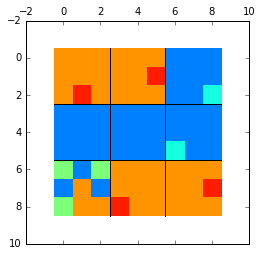

In [501]:
def sim_games(num = 1000):
    t0 = time.clock()
    for _ in range(num):
        game = Board()
        while not game.over:
            move = random.choice(game.legal_moves())
            game.update_move(move)
    print time.clock() - t0

    print game.over
    print game.result
    print_board(game)
cProfile.run('sim_games(100)',sort = 'cumtime')

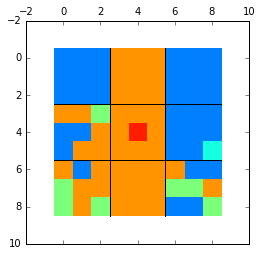

1


In [96]:
import random
import time
from IPython import display

board = np.array( [[ 0, 0,-1, 0, 0, 1, 0, 0, 0],
                   [ 0, 0, 1, 0, 0, 0, 0, 0,-1],
                   [ 0, 0, 0, 0, 0, 0, 1, 0,-1],
                   [ 0, 0, 0,-1, 0, 0, 0, 0, 0],
                   [ 0, 0, 0, 0, 0, 0, 0,-1, 0],
                   [ 0, 0, 1, 0, 1, 0, 0, 0, 0],
                   [ 1, 0, 0, 0, 0, 0, 0, 0, 0],
                   [ 0, 0, 0, 0, 1, 0, 0, 0, 0],
                   [ 0, 0, 0, 0, 1, 0,-1,-1, 0]])
active_board = (2,1)
game = Board(board=board,active_board=active_board)

while not game.over:
#     if len(game.legal_moves()) > 9:
#         print 'open'
#         break
    move = random.choice(game.legal_moves())
    game.update_move(move)
    display.clear_output(wait = True)
    print_board(game)
    plt.show()    
    time.sleep(0.5)
    if game.over:
        print game.result

(3, 4):     19 runs, +0.0000 eval,    0 won,    0 not lost,  inf not won,  inf lost,  3- 3 depth
(4, 4):    115 runs, +0.0000 eval,    0 won,    0 not lost,  inf not won,  inf lost,  3- 3 depth
(5, 3):     17 runs, +0.0000 eval,    0 won,    0 not lost,  inf not won,  inf lost,  3- 3 depth
 44 53 70 50 82 68 06 00 12 58 66 83


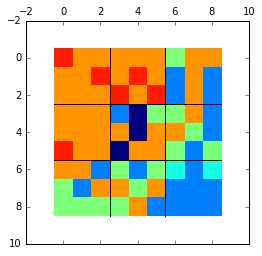

In [58]:
'''skullbreakz'''


def mc_pass(root,game):
#     node,moves = select(root,game,puct_constant = 0.2)
    node,moves = PN_select(root,game)
#     node,moves = PDN_select(root,game)
    expand(node,game)
#     result = evaluate(node,game)
    result = 0
    backprop(node,moves,result,prune = False)
    
    
    
import random
board_source = np.array( [[ 0,-1,-1, 1, 1, 1, 0, 1, 1],
                          [ 1,-1, 0,-1, 0,-1,-1, 1,-1],
                          [ 1, 1, 1, 0,-1, 0,-1, 1,-1],
                          [-1,-1, 1,-1, 0, 0, 0, 1,-1],
                          [-1,-1, 1, 1, 0, 1, 1, 0,-1],
                          [ 0,-1, 1, 0, 1, 1, 0,-1, 0],
                          [ 1, 1,-1, 0,-1, 0, 0,-1, 0],
                          [ 0,-1, 1, 1, 0, 1, 1, 1, 1],
                          [ 0, 0, 0, 0, 1,-1,-1,-1,-1]])
big_board_source = np.array([[1,1,0],
                             [1,0,0],
                             [0,0,-1]])
board = np.copy(board_source)
big_board = np.copy(big_board_source)
active_board = (1,1)
player = -1
game = Board(board=board,big_board = big_board,active_board=active_board,player = player)
game.log.append((1,7))
gamelog = list(game.log)
log_len = len(game.log)
print_board(game)
root = MC_node(game)
# t0 = time.clock()
for _ in range(100000):
#     while len(game.log) > log_len:
#         game.erase_move()
    board = np.copy(board_source)
    big_board = np.copy(big_board_source)
    game = Board(board=board,big_board = big_board,active_board=active_board,player = player)
    game.log = list(gamelog)
    mc_pass(root,game)
    if _ % 100 == 1 or all([child.solved and child.min_depth == child.max_depth for child in root.children.values()]):
        display.clear_output(wait = True)
        print_MC(root)
        print_principal(root)
        if  all([child.solved and child.min_depth == child.max_depth for child in root.children.values()]):
            break
# print '\n {}'.format(time.clock() - t0)

In [50]:
root.children[(4,4)].max_depth

5

In [40]:
all([child.min_depth == child.max_depth for child in root.children.values()])

True

In [44]:
for child in root.children.values():
    print child.min_depth
    print child.max_depth
    print child.min_depth == child.max_depth

2
5
False
2
3
False
1
3
False


In [67]:
for move,node in root.children.items():
    print move
    print node.GW, node.SL

(5, 3)
1 4
(4, 4)
1 3
(3, 4)
2 2
(3, 5)
1 1


C:\Users\Todd\Anaconda2\lib\site-packages\ipykernel\__main__.py:17: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\Todd\Anaconda2\lib\site-packages\ipykernel\__main__.py:23: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


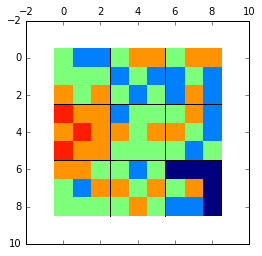

In [12]:
board_source = np.array( [[ 0,-1,-1, 0, 1, 1, 0, 1, 1],
                          [ 0, 0, 0,-1, 0,-1,-1, 0,-1],
                          [ 1, 0, 1, 0,-1, 0,-1, 1,-1],
                          [ 0,-1, 1,-1, 0, 0, 0, 1,-1],
                          [-1, 0, 1, 1, 0, 1, 1, 0,-1],
                          [ 0,-1, 1, 0, 0, 0, 0,-1, 0],
                          [ 1, 1, 0, 0,-1, 0, 0, 0, 0],
                          [ 0,-1, 1, 1, 0, 1, 0, 1, 0],
                          [ 0, 0, 0, 0, 1, 0,-1,-1, 0]])
big_board_source = np.array([[0,0,0],
                             [1,0,0],
                             [0,0,0]])
board = np.copy(board_source)
big_board = np.copy(big_board_source)
active_board = (2,2)
player = -1
game = Board(board=board,big_board = big_board,active_board=active_board,player = player)
game.log.append((5,2))
print_board(game)

run 2006700
cache 0
player 0
(0, 3): 1974448 runs, +0.7176 eval,   79 won,   79 not lost,   70 not won,   70 lost,  1- 1 depth
(0, 4):   7038 runs, +0.4920 eval,   31 won,   31 not lost,   14 not won,   14 lost,  1- 1 depth
(1, 3):   5393 runs, +0.4554 eval,   32 won,   32 not lost,   12 not won,   12 lost,  1- 1 depth
(1, 4):   4434 runs, +0.3987 eval,   38 won,   38 not lost,    7 not won,    7 lost,  1- 1 depth
(2, 3):   4894 runs, +0.4289 eval,   30 won,   30 not lost,   11 not won,   11 lost,  1- 1 depth
(2, 4):   4695 runs, +0.4166 eval,   40 won,   40 not lost,    8 not won,    8 lost,  1- 1 depth
(2, 5):   5798 runs, +0.4740 eval,   27 won,   27 not lost,   14 not won,   14 lost,  1- 1 depth
 03 21 65 17 33 12 38 27 84 63 20 82 88 86 71 55 67 23 62 28 66 11 44 43 51 75


KeyboardInterrupt: 

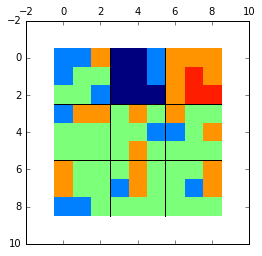

In [6]:
'''Ines A.'''


def mc_pass(root,game,branch = -1):
    node,moves = select(root,game,puct_constant = 1)
#     node = PN_select(root,game)
#     node,moves = PDN_select(root,game)
    if node.parent is None or node.parent().N[moves[-1]]>branch:
        expand(node,game)
    result = evaluate(node,game,depth = 0)
#     result = 0
    backprop(node,moves,result)
#     PN_backprop(node)
    
    
import random
board = np.zeros((9,9))
for x in [(6,0),(7,0),(5,4),(6,4),(7,4),(2,6),(7,8)]:
    board[x]=1
for o in [(0,0),(0,1),(8,0),(8,1),(7,3),(4,5),(7,7)]:
    board[o]=-1
big_board = np.array([[0,0,0],
                      [0,0,0],
                      [0,0,0]])

active_board = 'None'
player = 1
game = Board(board=board,big_board = big_board,active_board=active_board,player = player)
for move in [(3,4),(1,5),(4,8),(4,6),(3,1),(0,5),(0,6),(1,0),(3,2),(0,8),(1,6),(3,0),(0,2),(1,8),(3,6),(2,2),(6,8),(0,7)]:
    game.update_move(move)
log_len = len(game.log)
player = game.player
active_board = game.active_board
board_source = np.copy(game.board)
big_board_source = np.copy(game.big_board)
root = MC_node(game)
cache = {}
tact.fancy_board(game)
t0 = time.clock()
for _ in xrange(10000000):
#     board = np.copy(board_source)
#     big_board = np.copy(big_board_source)
#     game = Board(board=board,big_board = big_board,active_board=active_board,player = player)
    while len(game.log) > log_len:
        game.erase_move()
    mc_pass(root,game,3)
#     pn2_pass(root,game,cache,frac = 0.9)
    if _ % 100 == 0 or root.SL==0 or root.GW==0:
        display.clear_output(wait = True)
        print 'run',_
        print 'cache',len(cache)
        print 'player', player

#         print_board(game)
#         plt.draw()
        print_MC(root)
        print_principal(root)
        if root.SL==0 or root.GW == 0:
            break
tact.fancy_board(game)
print time.clock() - t0

In [12]:
kill_tree(root)
cache = {}

In [10]:
print game.replacement_legal_moves()
print game.legal_moves()
def get_legal(sims):
    for _ in range(sims):
        game.legal_moves()
        
def new_get_legal(sims):
    for _ in range(sims):
        game.replacement_legal_moves()
        
import cProfile
sims = 10000
cProfile.run('get_legal(sims)')
cProfile.run('new_get_legal(sims)')


[(3, 1), (3, 2), (4, 0), (4, 1), (4, 2), (5, 0), (5, 1)]
[(3, 1), (3, 2), (4, 0), (4, 1), (4, 2), (5, 0), (5, 1)]
         10004 function calls in 0.381 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.017    0.017    0.381    0.381 <ipython-input-10-0e254bae179a>:3(get_legal)
        1    0.000    0.000    0.381    0.381 <string>:1(<module>)
    10000    0.363    0.000    0.363    0.000 tictactics_bitlogic.py:183(legal_moves)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
        1    0.000    0.000    0.000    0.000 {range}


         20004 function calls in 0.386 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.017    0.017    0.386    0.386 <ipython-input-10-0e254bae179a>:7(new_get_legal)
        1    0.000    0.000    0.386    0.386 <string>:1(<module>)
    10000    0.164    0.000  

In [51]:
node = root.children[(0,2)].children[(0,7)].children[(0,3)].children[(2,0)].children[(6,2)].children[(2,7)].children[(6,3)
        ].children[(1,2)].children[(3,8)].children[(2,8)].children[(6,6)].children[(2,1)].children[(6,5)].children[(1,8)
        ].children[(3,6)].children[(2,2)].children[(6,8)].children[(1,7)].children[(3,3)].children[(1,1)].children[(5,3)
        ].children[(8,2)]
print node.N
print {key:float(node.V[key])/node.N[key] if node.N[key] !=0 else 0 for key in node.N}

{(7, 6): 0, (8, 8): 0, (6, 7): 2, (8, 7): 0}
{(7, 6): 0, (8, 8): 0, (6, 7): 1.0, (8, 7): 0}


In [87]:
for move,node in root.children[(4,4)].children[(3,5)].children[(2,6)].children[(7,2)].children.items():
    print move, node.GW,node.SL

(3, 8) 1 1
(4, 7) 1 1
(5, 8) 1 1
(3, 6) inf 0


In [38]:
for move in itertools.product(range(game.active_board[0]*3,game.active_board[0]*3+3) , range(game.active_board[1]*3,game.active_board[1]*3+3)):
    print move

(15, 9)
(15, 10)
(15, 11)
(16, 9)
(16, 10)
(16, 11)
(17, 9)
(17, 10)
(17, 11)


C:\Users\Todd\Anaconda2\lib\site-packages\ipykernel\__main__.py:17: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\Todd\Anaconda2\lib\site-packages\ipykernel\__main__.py:23: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


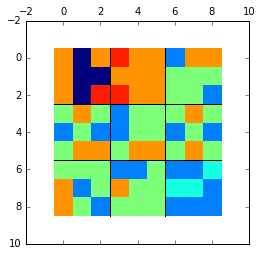

In [18]:
board_source = np.array( [[ 1, 0,-1, 0,-1, 1,-1, 1, 1],
                          [ 1, 0, 0,-1, 1, 1, 0, 0, 0],
                          [ 1, 0, 0, 0,-1, 1, 0, 0,-1],
                          [ 0, 1, 0,-1, 0, 0, 0, 1, 0],
                          [-1, 0,-1,-1, 0, 0,-1, 0,-1],
                          [ 0, 1, 1, 0, 1, 1, 0, 1, 0],
                          [ 0, 0, 0,-1,-1, 0, 1,-1, 0],
                          [ 1,-1, 0, 1, 0, 0, 0, 0, 1],
                          [ 1, 0,-1, 0, 0, 0,-1,-1,-1]])
big_board_source = np.array([[1,1,0],
                             [0,0,0],
                             [0,0,-1]])
board = np.copy(board_source)
big_board = np.copy(big_board_source)
active_board = (0,0)
player = -1
game = Board(board=board,big_board = big_board,active_board=active_board,player = player)
game.log.append((6,6))
print_board(game)

In [18]:
'''Jeffrey W'''

import cProfile
def mc_pass(root,game):
    node,moves = select(root,game,puct_constant = 0.75)
#     node= PN_select(root,game)
#     node,moves = PDN_select(root,game)
    expand(node,game)
    result = evaluate(node,game,depth = 0)
#     result = 0
    backprop(node,moves,result)
    
def MC_cell():
    import random
    board = np.zeros((9,9))
    for x in [(1,2),(0,5),(1,5),(2,6),(5,2),(6,0),(5,4),(7,4),(8,4)]:
        board[x]=1
    for o in [(0,2),(1,8),(2,8),(3,3),(4,6),(4,7),(6,4),(8,6),(8,7)]:
        board[o]=-1
    big_board = np.array([[0,0,0],
                          [0,0,0],
                          [0,0,0]])

    active_board = (1,0)
    player = 1
    game = Board(board=board,big_board = big_board,active_board=active_board,player = player)
    for move in [(5,1),(8,3),(7,0),(3,1),(2,5),(8,8),(6,7)]:
        game.update_move(move)
    log_len = len(game.log)
    player = game.player
    active_board = game.active_board
    board_source = np.copy(game.board)
    big_board_source = np.copy(game.big_board)
    root = MC_node(game)
#     tact.fancy_board(game)
    t0 = time.clock()
    for _ in range(100000000):
#         board = np.copy(board_source)
#         big_board = np.copy(big_board_source)
#         game = Board(board=board,big_board = big_board,active_board=active_board,player = player)
        while len(game.log) > log_len:
            game.erase_move()
        mc_pass(root,game,10)
        if _ % 100 == 0  or all([child.solved for child in root.children.values()]):
            display.clear_output(wait = True)
    #         print_board(game)
    #         plt.draw()
            print_MC(root)
            print_principal(root)
            if all([child.solved for child in root.children.values()]):
                break
#     print_board(game)
    print time.clock() - t0
    
cProfile.run('MC_cell()',sort = 'tottime')

(0, 3):     75 runs, -0.0933 eval,    4 won,    4 not lost,   16 not won,   16 lost,  1- 1 depth
(0, 4):    803 runs, -0.3736 eval,   15 won,   15 not lost,   25 not won,   25 lost,  1- 1 depth
(1, 3):    666 runs, -0.3514 eval,   12 won,   12 not lost,   30 not won,   30 lost,  1- 1 depth
(1, 4):    102 runs, -0.1667 eval,    5 won,    5 not lost,   18 not won,   18 lost,  1- 1 depth
(2, 3):    156 runs, -0.2372 eval,    5 won,    5 not lost,   21 not won,   21 lost,  1- 1 depth
(2, 4):    188 runs, -0.2660 eval,    5 won,    5 not lost,   24 not won,   24 lost,  1- 1 depth
 04 24 85 68 08 06 01 14 55
12.6118243617
         1600974 function calls in 12.662 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    82474    3.140    0.000    3.303    0.000 tictactics_bitlogic.py:137(legal_moves)
   109867    1.791    0.000    1.791    0.000 tictactics_bitlogic.py:225(check_board_win)
    90239    1.490    0.000    2.755    0.000 t

In [21]:
board = np.zeros((9,9))
for x in [(1,2),(0,5),(1,5),(2,6),(5,2),(6,0),(5,4),(7,4),(8,4)]:
    board[x]=1
for o in [(0,2),(1,8),(2,8),(3,3),(4,6),(4,7),(6,4),(8,6),(8,7)]:
    board[o]=-1
big_board = np.array([[0,0,0],
                      [0,0,0],
                      [0,0,0]])

active_board = (1,0)
player = 1
game = Board(board=board,big_board = big_board,active_board=active_board,player = player)
for move in [(5,1),(8,3),(7,0),(3,1),(2,5),(8,8),(6,7)]:
    game.update_move(move)
log_len = len(game.log)
player = game.player
active_board = game.active_board
board_source = np.copy(game.board)
big_board_source = np.copy(game.big_board)
root = MC_node(game)
tact.fancy_board(game)
t0 = time.clock()
print board
print big_board
print active_board
print player
game = Board(board=board,big_board = big_board,active_board=active_board,player = player)
game.moves

[[ 0.  0. -1.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  1.  0.  0. -1.]
 [ 0.  0.  0.  0.  0.  0.  1.  0. -1.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1. -1.  0.]
 [ 0.  0.  1.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0. -1. -1.  0.]]
[[0 0 0]
 [0 0 0]
 [0 0 0]]
(0, 1)
1


array([[2, 2, 3],
       [1, 2, 2],
       [1, 3, 2]], dtype=int64)

In [115]:
kill_tree(root)

In [112]:
board = np.copy(board_source)
big_board = np.copy(big_board_source)
game = Board(board=board,big_board = big_board,active_board=active_board,player = player)
while not game.over:
    evaluate(root,game,depth = 2)
log = game.log
# print log

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:17: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:23: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


-1


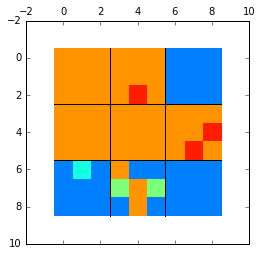

In [113]:
board = np.copy(board_source)
big_board = np.copy(big_board_source)
game = Board(board=board,big_board = big_board,active_board=active_board,player = player)

for move in log:

    game.update_move(move)
    if len(game.log) > len(log)-6:
        display.clear_output(wait = True)
        print game.player
        print_board(game)
        plt.show()
        time.sleep(3)

In [ ]:
'''Jeff S'''

root = None
cache  = {}
def mc_pass(root,game,branch = -1):
    node,moves = select(root,game,puct_constant = 0.75)
    if node.parent is None or node.parent().N[moves[-1]]>branch:
        expand(node,game) 
    result = evaluate(node,game,depth = 0)
    backprop(node,moves,result)
def profile_sim():
    global root
    global cache
    import random
    board = np.zeros((9,9))
    for x in [(0,1),(0,2),(4,1),(4,2),(8,1),(8,2)]:
        board[x]=1
    for o in [(1,1),(1,2),(2,7),(2,8),(6,1),(6,2)]:
        board[o]=-1
    big_board = np.array([[0,0,0],
                          [0,0,0],
                          [0,0,0]])

    active_board = (1,1)
    player = 1
    game = Board(board=board,big_board = big_board,player = player)
    for move in [(1,0),(3,1),(2,4),(8,4),(7,5),(4,8),(3,8),(0,8),(1,8),(3,7),(1,4),(5,4)]:
        game.update_move(move)
    log_len = len(game.log)
    player = game.player
    active_board = game.active_board
    board_source = np.copy(game.board)
    big_board_source = np.copy(game.big_board)
    root = MC_node(game)
    cache={}
    tact.fancy_board(game)
    t0 = time.clock()
    for _ in xrange(100000000):
    #     board = np.copy(board_source)
    #     big_board = np.copy(big_board_source)
    #     game = Board(board=board,big_board = big_board,active_board=active_board,player = player)
        while len(game.log) > log_len:
            game.erase_move()
        mc_pass(root,game,2)
#         PN_pass(root,game,cache)
#         pn2_pass(root,game,cache,depth=True)
        if _ % 1000 == 0 or root.SL==0 or root.GW==0:
            display.clear_output(wait = True)
    #         print_board(game)
    #         plt.draw()
            print player
            print len(cache)

            print_MC(root)
            print_principal(root)
            if root.SL==0 or root.GW == 0:
                break
    tact.fancy_board(game)
    print time.clock() - t0
# import cProfile
cProfile.run('profile_sim()',sort = 'tottime')
# %prun profile_sim()

0
0
(6, 5):   9436694 runs, +0.3606 eval,   60 won,   60 not lost,   22 not won,   22 lost,  1- 1 depth
(8, 5):    252513 runs, +0.3090 eval,   64 won,   64 not lost,   14 not won,   14 lost,  1- 1 depth
(6, 4):     93596 runs, +0.2983 eval,   52 won,   52 not lost,   14 not won,   14 lost,  1- 1 depth
(7, 3):     60022 runs, +0.2887 eval,   35 won,   35 not lost,   16 not won,   16 lost,  1- 1 depth
(6, 3):     12616 runs, +0.1741 eval,   21 won,   21 not lost,    6 not won,    6 lost,  1- 1 depth
(8, 3):      4559 runs, -0.1557 eval,   28 won,   28 not lost,    5 not won,    5 lost,  1- 1 depth
 65 17 45 57 64 05 16 51 85 68 06 21 73 40 30 22 87 74 44 43 52 78 46 50 80 72 47 35 26 71 34 04 13 32 07 23 70 00 20 60 03 58


In [7]:
kill_tree(root)

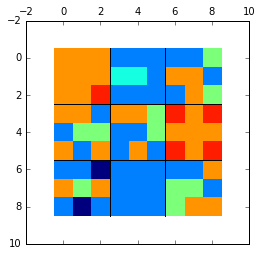

In [33]:
moves = map(lambda x: map(int,tuple(x)),print_principal(root).split())
print moves
board = np.zeros((9,9))
for x in [(0,0),(2,0),(1,7),(3,4),(7,2),(8,8)]:
    board[x]=1
for o in [(2,6),(5,5),(6,0),(6,4),(7,4),(7,8)]:
    board[o]=-1
big_board = np.array([[0,0,0],
                      [0,0,0],
                      [0,0,0]])

active_board = (1,1)
player = 1
game = Board(board=board,big_board = big_board,active_board=active_board,player = player)
for move in [(5,4),(8,4),(7,5),(4,8),(5,7),(7,3),(3,0),(2,1),(6,5),(1,8),(3,7),(2,4),(8,3),(6,1),(0,4),(1,5),(4,7)]:
    game.update_move(move)
for move in moves:
    display.clear_output(wait=True)
    game.update_move(move)
    tact.fancy_board(game)
    plt.show(block=True)
    time.sleep(1)
    
    

In [27]:
node = root.children[(1,5)].children[(4,7)].children[(4,4)].children[(3,3)]
print node.N
VoverN = {move : float(node.V[move]) / float(node.N[move]) if node.N >0 else 0. for move in node.N}
for move in VoverN:
    print '{} : moves = {:5d}, value = {:0.3f}'.format(move,node.N[move],VoverN[move])

{(0, 1): 1110, (1, 2): 3831, (1, 0): 225, (0, 2): 90, (2, 2): 262}
(0, 1) : moves =  1110, value = 0.083
(1, 2) : moves =  3831, value = 0.058
(1, 0) : moves =   225, value = 0.213
(0, 2) : moves =    90, value = 0.467
(2, 2) : moves =   262, value = 0.191


0.039734121812


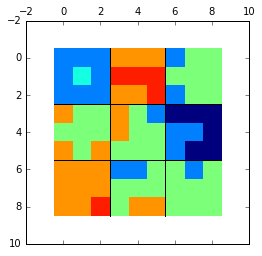

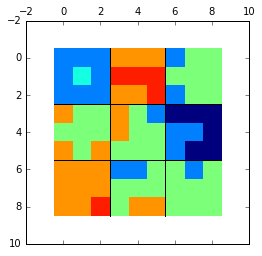

In [7]:
'''Filip T.'''
NODE = None
def mc_pass(root,game,branch = -1):
    node,moves = select(root,game,puct_constant = 0.75)
#     node = PN_select(root,game)
#     node,moves = PDN_select(root,game)
    if node.parent is None or node.parent().N[moves[-1]]>branch:
        expand(node,game)
        
    result = evaluate(node,game,depth = 0)
#     result = 0
    backprop(node,moves,result)
#     PN_backprop(node)

    
    
import random
board = np.zeros((9,9))
for x in [(7,1),(6,2),(5,2),(4,3)]:
    board[x]=1
for o in [(2,2),(3,5),(4,6),(4,7)]:
    board[o]=-1
big_board = np.array([[0,0,0],
                      [0,0,0],
                      [0,0,0]])

active_board = (1,1)
player = 1
game = Board(board=board,big_board = big_board,active_board=active_board,player = player)
for move in [(3,3),(2,1),(8,5),(6,7),(0,4),(2,4),(8,4),(6,4),(0,3),(2,0),(8,0),(7,0),(3,0),(0,0),(0,1),(2,3),(6,0),(1,0),
             (5,0),(6,1),(0,5),(0,6),(1,2),(5,6),(8,1),(6,3),(0,2),(2,6),(7,2)]:
    game.update_move(move)
log_len = len(game.log)
player = game.player
active_board = game.active_board
board_source = np.copy(game.board)
big_board_source = np.copy(game.big_board)
root = MC_node(game)
tact.fancy_board(game)
t0 = time.clock()


cache = {}
max_size = 1000000
frac = 0.1

count =0
for _ in xrange(00000000):
    
#     if root.SL > 250:
#         break
    count +=1
#     board = np.copy(board_source)
#     big_board = np.copy(big_board_source)
#     game = Board(board=board,big_board = big_board,active_board=active_board,player = player)
    while len(game.log) > log_len:
        game.erase_move()


#     mc_pass(root,game,3)
    pn2_pass(root,game,cache,frac = 0.75)
    if _ % 1 == 0 or root.SL==0 or root.GW==0:
        display.clear_output(wait = True)
#         print_board(game)
#         plt.draw()
        print count
        print 'player {}'.format(player)
        print 'cache size {}'.format(len(cache))
        
        
        print_MC(root)
        print_principal(root)
        if root.SL==0 or root.GW == 0:
            break
            
#     if _%1000 ==0:
#         prune_tree(root)
tact.fancy_board(game)
print time.clock() - t0

In [7]:
kill_tree(root)
cache=None

2040601
player 1
cache size 0
(0, 1):   3762 runs, +0.0832 eval,    4 won,    4 not lost,   24 not won,   24 lost,  1- 1 depth
(0, 2): 206357 runs, -0.1471 eval,   12 won,   12 not lost,   40 not won,   40 lost,  1- 1 depth
(1, 1):   1731 runs, +0.4073 eval,    4 won,    4 not lost,   15 not won,   15 lost,  1- 1 depth
(2, 1):  29468 runs, -0.1252 eval,    6 won,    6 not lost,   37 not won,   37 lost,  1- 1 depth
(2, 2): 1799282 runs, -0.2113 eval,   19 won,   19 not lost,   42 not won,   42 lost,  1- 1 depth
 22 87 75 56 81 65 26 72 58 88 86 80 82 76 50 62 16 40 32 08 17 54 73 42 38 27 74 35 07 04 15 46 41 53 60 01 25 66 11 44 55 67 23 71 13 30 21 64 70 31 06 02 61 77


KeyboardInterrupt: 

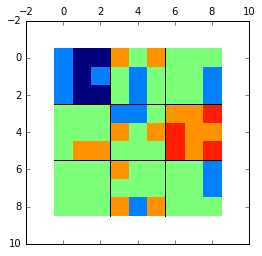

In [5]:
'''Libby S.'''
NODE = None
def mc_pass(root,game,branch = -1):
    node,moves = select(root,game,puct_constant = 0.75)
#     node = PN_select(root,game)
#     node,moves = PDN_select(root,game)
    if node.parent is None or node.parent().N[moves[-1]]>branch:
        expand(node,game)
        
    result = evaluate(node,game,depth = 0)
#     result = 0
    backprop(node,moves,result)
#     PN_backprop(node)

    
    
import random
board = np.zeros((9,9))
for x in [(0,3),(0,5),(5,1),(4,3),(4,5),(4,7),(3,7),(8,3),(8,5)]:
    board[x]=1
for o in [(1,0),(2,0),(1,4),(2,4),(1,8),(2,8),(3,3),(3,4),(6,8)]:
    board[o]=-1
big_board = np.array([[0,0,0],
                      [0,0,0],
                      [0,0,0]])

active_board = (1,1)
player = 1
game = Board(board=board,big_board = big_board,active_board=active_board,player = player)
for move in [(5,2),(7,8),(5,7),(8,4),(6,3),(0,0),(1,2),(4,8),(3,6)]:
    game.update_move(move)
log_len = len(game.log)
player = game.player
active_board = game.active_board
board_source = np.copy(game.board)
big_board_source = np.copy(game.big_board)
root = MC_node(game)
tact.fancy_board(game)
t0 = time.clock()


cache = {}
max_size = 1000000
frac = 0.1

count =0
for _ in xrange(100000000):
    
    count +=1
#     board = np.copy(board_source)
#     big_board = np.copy(big_board_source)
#     game = Board(board=board,big_board = big_board,active_board=active_board,player = player)
    while len(game.log) > log_len:
        game.erase_move()


    mc_pass(root,game,3)
#     pn2_pass(root,game,cache,frac = 0.75)
    if _ % 100 == 0 or root.SL==0 or root.GW==0:
        display.clear_output(wait = True)
#         print_board(game)
#         plt.draw()
        print count
        print 'player {}'.format(player)
        print 'cache size {}'.format(len(cache))
        
        
        print_MC(root)
        print_principal(root)
        if root.SL==0 or root.GW == 0:
            break
            
#     if _%1000 ==0:
#         prune_tree(root)
tact.fancy_board(game)
print time.clock() - t0

In [15]:
del root.children[(5,6)]
root.actions.remove((5,6))

529701
player 1
cache size 0
(6, 0):  10191 runs, -0.1720 eval,    4 won,    4 not lost,   23 not won,   23 lost,  1- 1 depth
(6, 1):   1582 runs, +0.1195 eval,    4 won,    4 not lost,    5 not won,    5 lost,  1- 1 depth
(6, 2): 516735 runs, -0.2248 eval,    6 won,    6 not lost,   41 not won,   41 lost,  1- 1 depth
(7, 1):   1192 runs, +0.2324 eval,    4 won,    4 not lost,    8 not won,    8 lost,  1- 1 depth
 62 27 73 40 32 08 16 51 65 06 21 75 36 22 88 87 63 00 12 46 30 02 07 15 57 85 78 37 05 17


KeyboardInterrupt: 

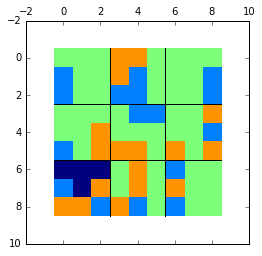

In [3]:
'''Pauline M.'''
NODE = None
def mc_pass(root,game,branch = -1):
    node,moves = select(root,game,puct_constant = 0.75)
    if node.parent is None or node.parent().N[moves[-1]]>branch:
        expand(node,game) 
    result = evaluate(node,game,depth = 0)
    backprop(node,moves,result)


    
    
import random
board = np.zeros((9,9))
for x in [(0,3),(1,3),(3,8),(4,2),(5,3),(5,4),(5,8),(6,4),(7,4)]:
    board[x]=1
for o in [(1,0),(2,0),(1,4),(2,4),(1,8),(2,8),(3,4),(3,5),(6,6)]:
    board[o]=-1
big_board = np.array([[0,0,0],
                      [0,0,0],
                      [0,0,0]])

player = 1
game = Board(board=board,big_board = big_board,player = player)
for move in [(0,4),(2,3),(8,0),(7,0),(5,2),(8,6),(7,2),(4,8),(5,6),(8,2),(7,6),(5,0),(8,1),(8,4),(8,3)]:
    game.update_move(move)
log_len = len(game.log)
player = game.player
root = MC_node(game)
tact.fancy_board(game)
t0 = time.clock()


cache = {}
max_size = 1000000
frac = 0.1

count =0
for _ in xrange(10000000):
    
    if root.SL > 250:
        break
    count +=1

    while len(game.log) > log_len:
        game.erase_move()


    mc_pass(root,game,5)
#     pn2_pass(root,game,cache,frac = 0.75)
    if _ % 100 == 0 or root.SL==0 or root.GW==0:
        display.clear_output(wait = True)

        print count
        print 'player {}'.format(player)
        print 'cache size {}'.format(len(cache))
        
        
        print_MC(root)
        print_principal(root)
        if root.SL==0 or root.GW == 0:
            break

tact.fancy_board(game)
print time.clock() - t0

9995001
player 0
cache size 0
(3, 1):   4728 runs, -0.0886 eval,   41 won,   41 not lost,    2 not won,    2 lost,  1- 1 depth
(4, 0):   7454 runs, +0.0855 eval,   50 won,   50 not lost,    4 not won,    4 lost,  1- 1 depth
(4, 1):   4923 runs, -0.0693 eval,   39 won,   39 not lost,    4 not won,    4 lost,  1- 1 depth
(5, 0):   5419 runs, -0.0275 eval,   15 won,   15 not lost,   10 not won,   10 lost,  1- 1 depth
(5, 1): 9902658 runs, +0.4126 eval,   23 won,   23 not lost,   86 not won,   86 lost,  1- 1 depth
(5, 2):  69818 runs, +0.3013 eval,   18 won,   18 not lost,   13 not won,   13 lost,  1- 1 depth
 51 83 80 60 12 38 06 10 32 07 15 58 67 04 13 52 66 00 22 86 70 31 14 55 76 40 50 61 24 53 72 37 03 20 71 33 21 17 54 35 05
8452.89418752


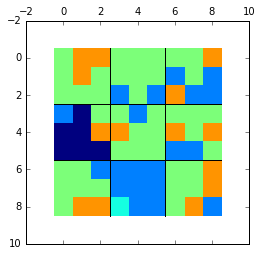

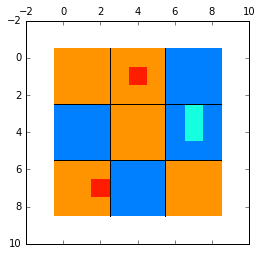

In [3]:
'''Pauline M.2'''
NODE = None
def mc_pass(root,game,branch = -1):
    node,moves = select(root,game,puct_constant = 0.75)
#     node = PN_select(root,game)
#     node,moves = PDN_select(root,game)
    if node.parent is None or node.parent().N[moves[-1]]>branch:
        expand(node,game)
        
    result = evaluate(node,game,depth = 0)
#     result = 0
    backprop(node,moves,result)
#     PN_backprop(node)

    
    
import random
board = np.zeros((9,9))
for x in [(1,1),(2,6),(4,2),(4,6),(6,4),(6,8),(8,2)]:
    board[x]=1
for o in [(2,3),(1,8),(2,8),(3,4),(6,2),(7,3),(7,4)]:
    board[o]=-1
big_board = np.array([[0,0,0],
                      [0,0,0],
                      [0,0,0]])

player = 1
game = Board(board=board,big_board = big_board,player = player)
for move in [(4,3),(3,0),(0,1),(2,5),(7,8),(5,6),(8,1),(7,5),(4,8),(5,7),(8,4),(6,3),(0,2),(2,7),(8,5),(8,8),(8,7),
             (6,5),(0,8),(1,6)]:
    game.update_move(move)
log_len = len(game.log)
player = game.player
active_board = game.active_board
board_source = np.copy(game.board)
big_board_source = np.copy(game.big_board)
root = MC_node(game)
tact.fancy_board(game)
t0 = time.clock()


cache = {}
max_size = 1000000
frac = 0.1

count =0
for _ in xrange(10000000):
    
#     if root.SL > 250:
#         break
    count +=1
#     board = np.copy(board_source)
#     big_board = np.copy(big_board_source)
#     game = Board(board=board,big_board = big_board,active_board=active_board,player = player)
    while len(game.log) > log_len:
        game.erase_move()


    mc_pass(root,game,5)
#     pn2_pass(root,game,cache,frac = 0.75)
    if _ % 5000 == 0 or root.SL==0 or root.GW==0:
        display.clear_output(wait = True)
#         print_board(game)
#         plt.draw()
        print count
        print 'player {}'.format(player)
        print 'cache size {}'.format(len(cache))
        
        
        print_MC(root)
        print_principal(root)
        if root.SL==0 or root.GW == 0:
            break
            
#     if _%1000 ==0:
#         prune_tree(root)
tact.fancy_board(game)
print time.clock() - t0

In [8]:
game.player

0

In [ ]:
'''Morgan R.'''
NODE = None
def mc_pass(root,game,branch = -1):
    node,moves = select(root,game,puct_constant = 0.75)
    if node.parent is None or node.parent().N[moves[-1]]>branch:
        expand(node,game) 
    result = evaluate(node,game,depth = 0)
    backprop(node,moves,result)

    
import random
board = np.zeros((9,9))
for x in [(1,0),(1,1),(0,6),(0,7),(3,5),(4,5),(8,2)]:
    board[x]=1
for o in [(0,1),(0,2),(1,8),(2,8),(4,1),(6,0),(7,0)]:
    board[o]=-1
big_board = np.array([[0,0,0],
                      [0,0,0],
                      [0,0,0]])

player = 1
game = Board(board=board,big_board = big_board,player = player)
for move in [(8,0),(8,1),(7,5),(3,7),(2,4),(8,5),(7,7),(4,3),(3,1),(1,5)]:
    game.update_move(move)
log_len = len(game.log)
player = game.player
root = MC_node(game)
tact.fancy_board(game)
t0 = time.clock()


cache = {}
max_size = 1000000
frac = 0.1

count =0
for _ in xrange(1000000000):
    
    count +=1

    while len(game.log) > log_len:
        game.erase_move()


    mc_pass(root,game,20)
#     pn2_pass(root,game,cache,frac = 0.75)
    if _ % 1000 == 0 or root.SL==0 or root.GW==0:
        display.clear_output(wait = True)

        print count
        print 'player {}'.format(player)
        print 'cache size {}'.format(len(cache))
        
        
        print_MC(root)
        print_principal(root)
        if root.SL==0 or root.GW == 0:
            break

tact.fancy_board(game)
print time.clock() - t0

62001
player 0
cache size 0
(4, 8):     39082 runs, +0.1963 eval,   29 won,   29 not lost,    7 not won,    7 lost,  1- 1 depth
(5, 8):      6593 runs, +0.1731 eval,   23 won,   23 not lost,    4 not won,    4 lost,  1- 1 depth
(5, 7):      6355 runs, +0.1717 eval,   22 won,   22 not lost,    4 not won,    4 lost,  1- 1 depth
(4, 6):      4665 runs, +0.1610 eval,   20 won,   20 not lost,    4 not won,    4 lost,  1- 1 depth
(5, 6):      1991 runs, +0.1070 eval,   11 won,   11 not lost,    4 not won,    4 lost,  1- 1 depth
(4, 7):      1766 runs, +0.0951 eval,    9 won,    9 not lost,    3 not won,    3 lost,  1- 1 depth
(3, 8):       884 runs, -0.0102 eval,    7 won,    7 not lost,    3 not won,    3 lost,  1- 1 depth
(3, 6):       664 runs, -0.0798 eval,    7 won,    7 not lost,    4 not won,    4 lost,  1- 1 depth
 48 58 67 04 13 42 47 53


3498901
player 1
cache size 0
(0, 6):  22954 runs, +0.2680 eval,   22 won,   22 not lost,   51 not won,   51 lost,  1- 1 depth
(0, 7):  25969 runs, +0.2609 eval,    9 won,    9 not lost,   81 not won,   81 lost,  1- 1 depth
(0, 8): 112026 runs, +0.2194 eval,   25 won,   25 not lost,  103 not won,  103 lost,  1- 1 depth
(1, 7): 265830 runs, +0.2122 eval,   36 won,   36 not lost,  103 not won,  103 lost,  1- 1 depth
(1, 8): 870682 runs, +0.2084 eval,   29 won,   29 not lost,  121 not won,  121 lost,  1- 1 depth
(2, 6): 2186674 runs, +0.2075 eval,   37 won,   37 not lost,  183 not won,  183 lost,  1- 1 depth
(2, 7):  14765 runs, +0.3019 eval,   12 won,   12 not lost,   43 not won,   43 lost,  1- 1 depth
 26 80 70 41 45 36 20 81 65 07 13 51 63 02 27 84 85 66 01 23 82 88 68 08 18 37 05 16 40


KeyboardInterrupt: 

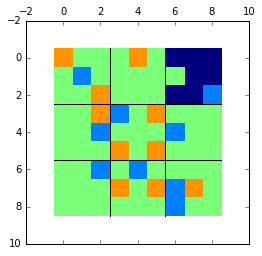

In [11]:
'''HVS_763447'''
NODE = None
def mc_pass(root,game,branch = -1):
    node,moves = select(root,game,puct_constant = 0.75)
    if node.parent is None or node.parent().N[moves[-1]]>branch:
        expand(node,game)
    result = evaluate(node,game,depth = 0)
    backprop(node,moves,result)

import random
board = np.zeros((9,9))
for x in [(0,0),(2,2),(0,4),(3,5),(5,3),(7,3),(7,5),(7,7)]:
    board[x]=1
for o in [(1,1),(2,8),(3,3),(4,2),(4,6),(6,2),(6,4),(8,6)]:
    board[o]=-1
big_board = np.array([[0,0,0],
                      [0,0,0],
                      [0,0,0]])

player = 1
game = Board(board=board,big_board = big_board,player = player)
for move in [(5,5),(7,6),(3,2)]:
    game.update_move(move)
log_len = len(game.log)
player = game.player
root = MC_node(game)
tact.fancy_board(game)
t0 = time.clock()


cache = {}
max_size = 1000000
frac = 0.1
count = 0


for _ in xrange(10000000):
    count+=1
    while len(game.log) > log_len:
        game.erase_move()


    mc_pass(root,game,1)
#     pn2_pass(root,game,cache,frac = 0.75)
    if _ % 100 == 0 or root.SL==0 or root.GW==0:
        display.clear_output(wait = True)
        print count
        print 'player {}'.format(player)
        print 'cache size {}'.format(len(cache))
        print_MC(root)
        print_principal(root)
        if root.SL==0 or root.GW == 0:
            break

tact.fancy_board(game)
print time.clock() - t0

In [53]:
moves = []
def check_parents(node,moves):
    if node.leaf:
        return
    for move in node.actions:
        moves.append(move)
        child = node.children[move]
        if child.parent is None:
            print moves
            return
        check_parents(child,moves)
        moves.pop()
check_parents(root,moves)

In [143]:
print board_source
board = np.copy(board_source)
big_board = np.copy(big_board_source)
game = Board(board=board,big_board = big_board,active_board=active_board,player = player)
print game.board
game.update_move((0,1))
game.update_move((2,4))
game.legal_moves()

[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.  0. -1.  0.  0.]
 [ 1.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.]
 [ 0.  0.  0.  0.  1. -1.  0.  1.  0.]
 [-1.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  1. -1. -1.  1.  0.  0. -1.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.  1.]]
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.  0. -1.  0.  0.]
 [ 1.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.]
 [ 0.  0.  0.  0.  1. -1.  0.  1.  0.]
 [-1.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  1. -1. -1.  1.  0.  0. -1.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.  1.]]


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:17: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:23: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


[(6, 3), (6, 5), (8, 3), (8, 5)]

In [45]:
backprop()

True

In [35]:
game.result

2

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:17: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:23: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


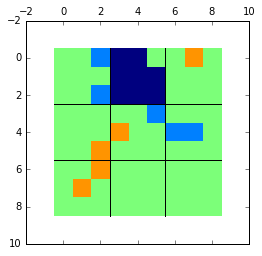

In [24]:
#02 07 24 75 48 58 67 13 41 34 15 36 21

board = np.copy(board_source)
big_board = np.copy(big_board_source)
game = Board(board=board,big_board = big_board,active_board=active_board,player = player)

for move in [(0,2),(0,7)]:
    game.update_move(move)
print_board(game)

In [171]:
kill_tree(root)

In [31]:
def solved_nodes(node):
    solved = 0
    for child in node.children.values():
        solved += solved_nodes(child)
    if node.GW == 0 or node.SL ==0 or (node.GT== 0 and node.ST == 0):
        solved += 1
    return solved

### connect four

In [47]:
import connect_four_bitlogic as cccc

transpositions in upper tree: 159
player 2
cache size: 4845
run: 1665
time calculating: 604.94
0:     67 runs, +0.0000 eval,    0 won,    0 not lost,  inf not won,  inf lost,  1- 1 depth
1:     67 runs, +0.0000 eval,    0 won,    0 not lost,  inf not won,  inf lost,  1- 1 depth
2:     64 runs, +0.0000 eval,    0 won,    0 not lost,  inf not won,  inf lost,  1- 1 depth
3:     71 runs, +0.0000 eval,    0 won,    0 not lost,  inf not won,  inf lost,  1- 1 depth
4:   1737 runs, +0.0000 eval,  inf won,  inf not lost,    0 not won,    0 lost,  1- 1 depth
5:     75 runs, +0.0000 eval,    0 won,    0 not lost,  inf not won,  inf lost,  1- 1 depth
6:     55 runs, +0.0000 eval,    0 won,    0 not lost,  inf not won,  inf lost,  1- 1 depth
605.166705156
player 2
         109772583 function calls (106633374 primitive calls) in 605.169 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   708338   76.786    0.000   95.569    0.000 <ipython

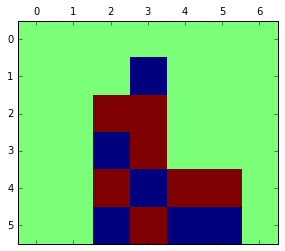

In [79]:
def mc_pass(root,game):
#     node,moves = select(root,game,puct_constant = 0.5)
    node,moves = PN_select(root,game)
#     node,moves = PDN_select(root,game)
    expand(node,game)
#     result = evaluate(node,game,depth=0)
    result = 0
    backprop(node,moves,result,prune=False)
    
def PN_pass(root,game,cache=None,depth = False):
    if cache is None:
        cache = {}
    node= PN_select(root,game,cache)
    if node.leaf:
        expand(node,game)

    PN_backprop(node,cache=cache,depth = depth)



def pn2_pass(root,game,cache,frac = 0.25,min_size = 1,max_size = 100000,depth = False):
#     cache[root.key] = root
    cache2 = {'transpositions':0}
    node = PN_select(root,game,cache)
    
    
    if node.leaf and not node.solved:
        if not game.over:#PN2

            log_len2 = len(game.log)
            root2 = node
            if node.parent:
                parent = node.parent()
            else:
                parent = None
            node.parent = None
#             try:


            size2 = min(max(min_size,len(cache)*frac) , max_size - len(cache))
#             size2 = 100
#                 print size2
            if size2 < 0:
                return None
            counter = 0
            while len(cache2)* frac + 0 * cache2['transpositions']< size2 and not root2.solved:
                counter +=1
                while log_len2 < len(game.log):
                    game.erase_move()
                PN_pass(root2,game,cache = cache2,depth = depth)

            while log_len2 < len(game.log):
                game.erase_move()

            for child in root2.children.values():
                cache2[child.key] = child
                for grandchild in child.children.values():
                    kill_tree(grandchild)
                child.leaf = True
#             except Exception as e:
#                 if parent is not None:
#                     node.parent=weakref.ref(parent)
#                 print e
#                 sys.exit('pn2 error')
            if parent is not None:
                node.parent = weakref.ref(parent)
        
    for child in node.children.values():
        if not child.key in cache:
            cache[child.key] = child
    PN_backprop(node,cache=cache,depth = depth)
#     print 'transpositions in lower tree: {}'.format(cache2['transpositions'])

def board_to_cache(game):
    return game.bit1,game.bit2


def print_c4(node):
    for move in node.actions:
        print '{}: {:6d} runs, {:+0.4f} eval, {:} W, {:} GT, {} ST, {} L'.format(
            move,
            node.N[move],
            0. if node.N[move] == 0 else float(node.V[move]) / node.N[move],
            node.children[move].GW,
            node.children[move].GT,
            node.children[move].ST,
            node.children[move].SL)

def print_principal_c4(node):
    s = ''
    while not node.leaf:
        if node.player == 1:
            move = min([(node.children[move].GW,node.children[move].GT,move) for move in node.actions])[-1]
        if node.player == -1:
            move = min([(node.children[move].SL,node.children[move].ST,move) for move in node.actions])[-1]
        s = s + ' ' + str(move)
        if move in node.children:
            node = node.children[move]
        else:
            break
    print s
    
cache = {'transpositions':0}
cache2={}
max_size = 1000000
frac = 0.1
root = None
def c4_cell(cache):
    global root
    game = cccc.Board()
    moves = [3,3,3,2,2,2,3,4,4,5,5,3,2]
    for move in moves:
        game.update_move(move)
    loglen = len(game.log)

    root = MC_node(game)

    # root= root.children[4]
    t0 = time.clock()
    player = game.player
    for _ in range(1000000):

    #     game = cccc.Board()
    #     for move in moves:
    #         game.update_move(move)

        while len(game.log) > loglen:
            game.erase_move()
#         PN_pass(root,game,cache)
        pn2_pass(root,game,cache,depth = False)
        if _ % 1 == 0 or all([child.solved and child.min_depth == child.max_depth for child in root.children.values()]):
    #     if _%100==0:
            display.clear_output(wait = True)
            print 'transpositions in upper tree: {}'.format(cache['transpositions'])
            print 'player {}'.format(1 if player==1 else 2)
            print 'cache size: {}'.format(len(cache))
            print 'run: {}'.format(_)
            print 'time calculating: {:5.2f}'.format(time.clock() - t0)
            print_MC(root)
    #         print_principal_c4(root)
            
            if all([child.solved and child.min_depth == child.max_depth for child in root.children.values()]):
                break
        if root.solved:
            break


    #     if _%1000 ==0:
    #         prune_tree(root)
    game = cccc.Board()
    for move in moves:
        game.update_move(move)
    plt.matshow(game.print_board(),vmin=-1,vmax=1)
    print time.clock() - t0
    print 'player {}'.format(1 if 1 == game.player else 2)
import cProfile
cProfile.run('c4_cell(cache)',sort = 'tottime')
# c4_cell(cache)

In [74]:
cache = {}

In [36]:
BITS = np.arange(48).reshape((6,8)).astype(long)
board = np.array([[ 0 , 0,  0,  0 , 0 , 0,  0],
 [ 0 , 0 , 0 , 0 , 0 , 0  ,0],
 [ 0  ,0 , 1 , 1 , 0 , 0 , 0],
 [ 0 , 0, -1  ,1,  0,  0 , 0],
 [ 0 , 0 , 1 ,-1 , 1 , 0 , 0],
 [-1, -1 ,-1 , 1 ,-1  ,0 , 0]])
np.concatenate((board==1 , np.zeros((6,1))),axis=1)* (1L<<BITS)

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   2.62144000e+05,
          5.24288000e+05,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.34217728e+08,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.71798692e+10,
          0.00000000e+00,   6.87194767e+10,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          8.79609302e+12,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.0

In [50]:
what = np.sum((1L<<BITS)*np.concatenate((board==-1 , np.zeros((6,1))),axis=1).astype(long))
what

25323194286080

In [118]:
for child in root.children.values():
    print child.min_depth==child.max_depth

True
False
True
False
True
True


In [100]:
root.children[0].children[0].children

{}

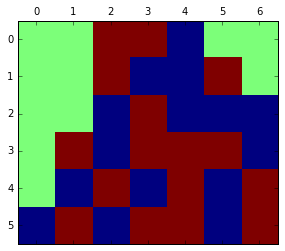

In [45]:
print root.children[(6,0)].children[(0,1)].children[(1,5)].children[(4,8)].children[(3,6)]

<__main__.MC_node instance at 0x0000000088B36DC8>


# Heuristic

In [185]:
board = np.array([[-1, 0, 0],
                  [-1, 1, 0],
                  [ 1, 0, 1]])

In [186]:
threat=2
dummy = threat*(board==1)+(board==0)
print dummy
p1cols= np.prod(dummy,axis=0)
p1rows= np.prod(dummy,axis=1)
p1rdiag=dummy[0,0]*dummy[1,1]*dummy[2,2]
p1ldiag=dummy[0,2]*dummy[1,1]*dummy[2,0]
dummy = threat*(board==-1)+(board==0)
print dummy
p2cols= np.prod(dummy,axis=0)
p2rows= np.prod(dummy,axis=1)
p2rdiag=dummy[0,0]*dummy[1,1]*dummy[2,2]
p2ldiag=dummy[0,2]*dummy[1,1]*dummy[2,0]

[[0 1 1]
 [0 2 1]
 [2 1 2]]
[[2 1 1]
 [2 0 1]
 [0 1 0]]


In [201]:
def threat(board,coef=2):
    threat=2
    dummy = threat*(board==1)+(board==0)
    p1cols= np.prod(dummy,axis=0)
    p1rows= np.prod(dummy,axis=1)
    p1rdiag=dummy[0,0]*dummy[1,1]*dummy[2,2]
    p1ldiag=dummy[0,2]*dummy[1,1]*dummy[2,0]
    p1threat = np.add.outer(p1rows,p1cols) + p1rdiag * np.eye(3) + p1ldiag * np.flipud(np.eye(3))
    p1threat *= (board==0)
    dummy = threat*(board==-1)+(board==0)
    p2cols= np.prod(dummy,axis=0)
    p2rows= np.prod(dummy,axis=1)
    p2rdiag=dummy[0,0]*dummy[1,1]*dummy[2,2]
    p2ldiag=dummy[0,2]*dummy[1,1]*dummy[2,0]
    p2threat = np.add.outer(p2rows,p2cols) + p2rdiag * np.eye(3) + p2ldiag * np.flipud(np.eye(3))
    p2threat *= (board==0)
    return p1threat+p2threat

In [433]:
board = np.zeros((9,9))
for x in [(6,0),(7,0),(5,4),(6,4),(7,4),(2,6),(7,8)]:
    board[x]=1
for o in [(0,0),(0,1),(8,0),(8,1),(7,3),(4,5),(7,7)]:
    board[o]=-1
big_board = np.array([[0,0,0],
                      [0,0,0],
                      [0,0,0]])

active_board = 'None'
player = 1
game = Board(board=board,big_board = big_board,active_board=active_board,player = player)
for move in [(3,4),(1,5),(4,8),(4,6),(3,1),(0,5),(0,6)]:
    game.update_move(move)
    
board = game.board
big = game.big_board

C:\Users\Todd\Anaconda2\lib\site-packages\ipykernel\__main__.py:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\Todd\Anaconda2\lib\site-packages\ipykernel\__main__.py:25: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [434]:
print board
print big
threat(big)


[[-1. -1.  0.  0.  0. -1.  1.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  1.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1. -1.  0.  1.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0. -1.  1.  0.  0. -1.  1.]
 [-1. -1.  0.  0.  0.  0.  0.  0.  0.]]
[[0 0 0]
 [0 0 0]
 [0 0 0]]


array([[ 6.,  4.,  6.],
       [ 4.,  8.,  4.],
       [ 6.,  4.,  6.]])

In [466]:
best_reply = np.zeros((9,9))
threat_board = np.zeros((9,9))
for i in range(3):
    for j in range(3):
        threat_board[3*i:3*i+3,3*j:3*j+3] = threat(board[3*i:3*i+3,3*j:3*j+3]) * threat(big)[i,j]
master_threat = np.copy(threat_board)

In [467]:
print board
print master_threat

[[-1. -1.  0.  0.  0. -1.  1.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  1.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1. -1.  0.  1.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0. -1.  1.  0.  0. -1.  1.]
 [-1. -1.  0.  0.  0.  0.  0.  0.  0.]]
[[  0.   0.  48.  24.  16.   0.   0.  24.  36.]
 [ 24.  48.  24.  16.  32.   0.  36.  48.  24.]
 [ 36.  24.  36.  24.  16.  32.   0.  24.  36.]
 [ 24.   0.  24.  48.   0.  48.  24.  16.  24.]
 [ 16.  32.  16.  32.  80.   0.   0.  24.   0.]
 [ 24.  16.  24.  48.   0.  48.  24.  16.  24.]
 [  0.  24.  36.  24.   0.  24.  36.  24.  36.]
 [  0.  48.  24.   0.   0.   8.  12.   0.   0.]
 [  0.   0.  48.  24.  24.  24.  36.  24.  36.]]


array([[-24.,   8.,  12.],
       [ 20.,  16.,   8.],
       [-24.,   8.,  12.]])

23.26528
[[-1. -1.  0.  0.  0. -1.  1.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  1.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1. -1.  0.  1.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0. -1.  1.  0.  0. -1.  1.]
 [-1. -1.  0.  0.  0.  0.  0.  0.  0.]]
[[  0.        0.       20.10112  -0.69888  -2.04288   0.        0.
    5.95712   8.10112]
 [ 11.2       2.10432  12.35712   3.2     -13.89568   0.       23.2
    2.10432  12.35712]
 [  5.15712   9.83808  14.75712  -6.84288   1.83808  10.75712   0.
    9.83808  14.75712]
 [ -0.69888   0.       -3.89888  23.30112   0.       20.10112  -0.69888
   -2.04288  -3.89888]
 [  3.2     -13.89568   4.35712  19.2      34.10432   0.        0.
  -21.89568   0.     ]
 [ -6.84288   1.83808   2.75712  17.15712   0.       26.75712  -6.84288
    1.83808   2.75712]
 [  0.        5.95712   8.10112  -0.69888   0.       -3.89888  11.30112
    5.95712   8.

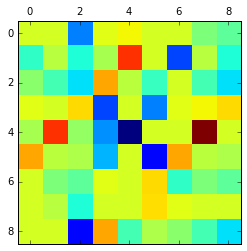

In [440]:

for i in range(9):
    for j in range(9):
        loci=i%3
        locj=j%3
        best_reply[i,j] = np.max(threat_board[3*loci:3*loci+3,3*locj:3*locj+3])
new_threat_board = master_threat - 0.8*best_reply*(board==0)

print np.max(np.abs(new_threat_board - threat_board))
threat_board = new_threat_board

print board
print threat_board
plt.matshow(-threat_board)

In [462]:
def ttt_threat(board,big,decay = 0.75):
    board = np.copy(board)
    big = np.copy(big)
    best_reply = np.zeros((9,9))
    master_threat = np.zeros((9,9))
    for i in range(3):
        for j in range(3):
            master_threat[3*i:3*i+3,3*j:3*j+3] = threat(board[3*i:3*i+3,3*j:3*j+3]) * threat(big)[i,j]
    current_threat = np.copy(master_threat)
    counter = 0
    errors = []
    while True:
        counter +=1
        for i in range(9):
            for j in range(9):
                loci=i%3
                locj=j%3
                best_reply[i,j] = np.max(current_threat[3*loci:3*loci+3,3*locj:3*locj+3])
        new_threat = master_threat - decay*best_reply*(board==0)
        error = np.max(np.abs(new_threat-current_threat))
        errors.append(error)
        if  error< 1 or counter > 100:
            return new_threat,counter,errors
        current_threat = new_threat
    
    

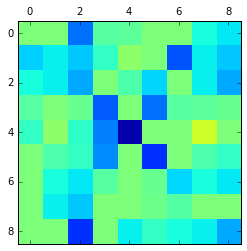

In [463]:
plt.matshow(-ttt_threat(board,big)[0],vmax=50,vmin=-50)

[[ 6.  4.  6.]
 [ 4.  8.  4.]
 [ 6.  4.  6.]]
[[  0.  24.  36.]
 [ 36.  48.  24.]
 [  0.  24.  36.]]
[[  0.   8.  12.]
 [ 20.  16.   8.]
 [  0.   8.  12.]]


0.1614450007036794

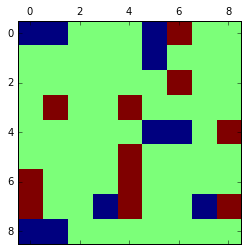

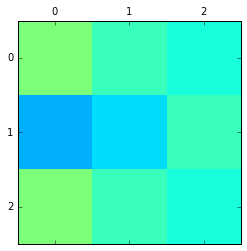

In [484]:
plt.matshow(board)
t0 = time.clock()
threat_board = np.zeros((3,3))
i,j = (0,2)
active = board[3*i:3*i+3,3*j:3*j+3]
big_threat = threat(big)
print big_threat
threat_board = threat(active) * big_threat[i,j]
print threat_board
guess = threat_board - 4*big_threat*(active == 0)
plt.matshow(-guess,vmin=-50,vmax=50)
print guess
time.clock()-t0

In [470]:
ttt_threat(board,big)


(array([[  0.        ,   0.        ,  26.53856291,   4.36668791,
           3.72606291,   0.        ,   0.        ,  11.72606291,
          14.53856291],
        [ 16.97606291,  14.04455411,  17.72606291,   8.97606291,
          -1.95544589,   0.        ,  28.97606291,  14.04455411,
          17.72606291],
        [ 11.72606291,  13.81737527,  20.72606291,  -0.27393709,
           5.81737527,  16.72606291,   0.        ,  13.81737527,
          20.72606291],
        [  4.36668791,   0.        ,   2.53856291,  28.36668791,
           0.        ,  26.53856291,   4.36668791,   3.72606291,
           2.53856291],
        [  8.97606291,  -1.95544589,   9.72606291,  24.97606291,
          46.04455411,   0.        ,   0.        ,  -9.95544589,   0.        ],
        [ -0.27393709,   5.81737527,   8.72606291,  23.72606291,
           0.        ,  32.72606291,  -0.27393709,   5.81737527,
           8.72606291],
        [  0.        ,  11.72606291,  14.53856291,   4.36668791,
           0.       

In [1]:
import connect_four_bitlogic as cccc
import random
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
game = cccc.Board()
game.legal_moves()

[0, 1, 2, 3, 4, 5, 6]

[]
True
1


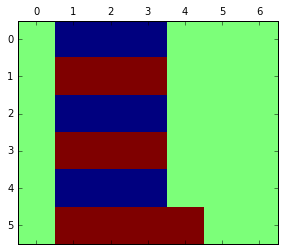

In [25]:
move = 4
game.update_move(move)
print game.legal_moves()
print game.over
print game.result
plt.matshow(game.print_board(),vmax=1,vmin=-1)

In [3]:
import cProfile
def sim_c4(num):
#     game = cccc.Board()
    for _ in range(num):
#         while game.bit1 or game.bit2:
#             game.erase_move()
        game = cccc.Board()
        while not game.over:
            move = random.choice(game.legal_moves())
            game.update_move(move)

cProfile.run('sim_c4(10000)',sort = 'tottime')

         1718140 function calls in 6.496 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   213514    1.786    0.000    3.451    0.000 connect_four_bitlogic.py:54(update_move)
   213514    1.630    0.000    1.630    0.000 connect_four_bitlogic.py:111(legal_moves)
   213514    1.527    0.000    1.527    0.000 connect_four_bitlogic.py:123(winner)
        1    0.768    0.768    6.496    6.496 <ipython-input-3-ab3adaf7d186>:2(sim_c4)
   213514    0.484    0.000    0.584    0.000 random.py:273(choice)
   203538    0.070    0.000    0.070    0.000 {all}
   213514    0.067    0.000    0.067    0.000 {method 'append' of 'list' objects}
    10000    0.058    0.000    0.062    0.000 connect_four_bitlogic.py:9(__init__)
   213514    0.055    0.000    0.055    0.000 {method 'random' of '_random.Random' objects}
   213514    0.045    0.000    0.045    0.000 {len}
    10000    0.004    0.000    0.004    0.000 connect_four_bitlogic.py:108

In [54]:
node,moves = PN_select(root,game)

In [60]:
print moves
print node
print node.parent().children[3]

[1, 3]
<__main__.MC_node instance at 0x000000001A3C2388>
<__main__.MC_node instance at 0x000000001A3C2388>


# Comparing bitlogic with naive

In [5]:
import cProfile
import tictactics_bitlogic as tact
import random

sims = 1000

def play(sims):
    d = {0:0,1:0,2:0,-2:0,-1:0}
    board = np.zeros((9,9))
    for x in [(0,0),(2,0),(1,7),(3,4),(7,2),(8,8)]:
        board[x]=1
    for o in [(2,6),(5,5),(6,0),(6,4),(7,4),(7,8)]:
        board[o]=-1
    big_board = np.array([[0,0,0],
                          [0,0,0],
                          [0,0,0]])

    active_board = (1,1)
    player = 1
    game = Board(board=board,big_board = big_board,active_board=active_board,player = player)
    loglen = len(game.log)
    for _ in range(sims):
        while not game.over:
            move = random.choice(game.legal_moves())
            game.update_move(move)
        d[game.result]+=1
        while len(game.log) > loglen:
            game.erase_move()
    print d
def bitPlay(sims):
    d = {0:0,1:0,2:0,-2:0,-1:0}
    board = np.zeros((9,9))
    for x in [(0,0),(2,0),(1,7),(3,4),(7,2),(8,8)]:
        board[x]=1
    for o in [(2,6),(5,5),(6,0),(6,4),(7,4),(7,8)]:
        board[o]=-1
    big_board = np.array([[0,0,0],
                          [0,0,0],
                          [0,0,0]])

    active_board = (1,1)
    player = 1
    game = tact.Board(board=board,big_board = big_board,active_board=active_board,player = player)
    loglen = len(game.log)
    for _ in range(sims):
        while not game.over:
            move = random.choice(game.legal_moves())
            game.update_move(move)
        d[game.result] +=1
        while len(game.log) > loglen:
            game.erase_move()   
    print d
    
cProfile.run('play(sims)',sort = 'tottime')
cProfile.run('bitPlay(sims)',sort='tottime')
            
            


{0: 0, 1: 529, 2: 36, -1: 394, -2: 41}
         3001649 function calls in 18.850 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   106072    7.698    0.000   12.915    0.000 <ipython-input-1-7cb1e1e8d469>:110(check_board_win)
   109296    3.066    0.000    3.426    0.000 <ipython-input-1-7cb1e1e8d469>:83(legal_moves)
   300755    2.147    0.000    2.147    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   212144    1.122    0.000    3.139    0.000 fromnumeric.py:1743(sum)
   424288    0.990    0.000    0.990    0.000 {method 'astype' of 'numpy.ndarray' objects}
    54648    0.819    0.000    9.031    0.000 <ipython-input-1-7cb1e1e8d469>:34(update_move)
    54648    0.527    0.000    7.315    0.000 <ipython-input-1-7cb1e1e8d469>:56(erase_move)
        1    0.447    0.447   18.850   18.850 <ipython-input-5-554505017f85>:7(play)
    88611    0.360    0.000    1.087    0.000 fromnumeric.py:2433(prod)
    99310    0.346    0.

C:\Users\Todd\Anaconda2\lib\site-packages\ipykernel\__main__.py:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\Todd\Anaconda2\lib\site-packages\ipykernel\__main__.py:25: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


1360001
player 0
cache size 0
(6, 0):   1252132 runs, +0.3517 eval,   33 won,   33 not lost,   15 not won,   15 lost,  1- 1 depth
(8, 0):     26403 runs, +0.3192 eval,   33 won,   33 not lost,    6 not won,    6 lost,  1- 1 depth
(6, 2):     20203 runs, +0.3090 eval,   27 won,   27 not lost,   10 not won,   10 lost,  1- 1 depth
(8, 2):     19943 runs, +0.3085 eval,   35 won,   35 not lost,    8 not won,    8 lost,  1- 1 depth
(7, 0):     19828 runs, +0.3083 eval,   32 won,   32 not lost,    6 not won,    6 lost,  1- 1 depth
(8, 1):     16385 runs, +0.2989 eval,   29 won,   29 not lost,   10 not won,   10 lost,  1- 1 depth
(6, 1):      3404 runs, +0.0955 eval,   13 won,   13 not lost,    6 not won,    6 lost,  1- 1 depth
(7, 1):      1702 runs, -0.1616 eval,    6 won,    6 not lost,    3 not won,    3 lost,  1- 1 depth
 60 21 83 80 82 78 57 63 20 81 84 85 66 02 28 86 70 30 22 87 73 52 88 76 40 51 65 16 42 38 17


KeyboardInterrupt: 

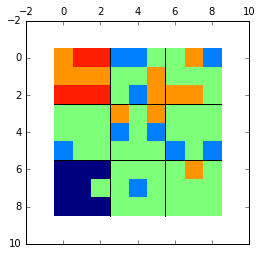

In [3]:
'''Hawkay R.'''
NODE = None
def mc_pass(root,game,branch = -1):
    node,moves = select(root,game,puct_constant = 0.75)
    if node.parent is None or node.parent().N[moves[-1]]>branch:
        expand(node,game) 
    result = evaluate(node,game,depth = 0)
    backprop(node,moves,result)

    
import random
board = np.zeros((9,9))
for x in [(1,0),(1,1),(1,5),(2,5),(2,6),(2,7),(3,3),(3,5),(6,7)]:
    board[x]=1
for o in [(0,0),(0,4),(0,8),(2,4),(5,0),(4,3),(4,5),(5,8),(7,4)]:
    board[o]=-1
big_board = np.array([[0,0,0],
                      [0,0,0],
                      [0,0,0]])

player = 1
game = Board(board=board,big_board = big_board,player = player)
for move in [(0,7),(0,3),(1,2),(5,6)]:
    game.update_move(move)
log_len = len(game.log)
player = game.player
root = MC_node(game)

#remove illegal moves on first turn
# for move in [(1,2),(0,5),(2,8),(3,4),(4,4)]:
#     root.actions.remove(move)
    
    
tact.fancy_board(game)
t0 = time.clock()


cache = {}
max_size = 1000000
frac = 0.1

count =0
for _ in xrange(10000000):

    count +=1

    while len(game.log) > log_len:
        game.erase_move()


    mc_pass(root,game,5)
#     pn2_pass(root,game,cache,frac = 0.75)
    if _ % 1000 == 0 or root.SL==0 or root.GW==0:
        display.clear_output(wait = True)

        print count
        print 'player {}'.format(player)
        print 'cache size {}'.format(len(cache))
        
        
        print_MC(root)
        print_principal(root)
        if root.SL==0 or root.GW == 0:
            break

tact.fancy_board(game)
print time.clock() - t0

2184001
player 0
cache size 0
(3, 3): 1726490 runs, +0.0481 eval,  122 won,  122 not lost,   50 not won,   50 lost,  1- 1 depth
(3, 5):  35216 runs, +0.0163 eval,   42 won,   42 not lost,   16 not won,   16 lost,  1- 1 depth
(5, 4):  22860 runs, -0.0002 eval,   52 won,   52 not lost,   23 not won,   23 lost,  1- 1 depth
(5, 5):  21076 runs, -0.0042 eval,   44 won,   44 not lost,   18 not won,   18 lost,  1- 1 depth
(4, 3):  16222 runs, -0.0199 eval,   43 won,   43 not lost,   11 not won,   11 lost,  1- 1 depth
(0, 3):   9990 runs, -0.0624 eval,   33 won,   33 not lost,   21 not won,   21 lost,  1- 1 depth
(0, 6):   9558 runs, -0.0674 eval,   36 won,   36 not lost,    7 not won,    7 lost,  1- 1 depth
(6, 2):   8586 runs, -0.0806 eval,   25 won,   25 not lost,   20 not won,   20 lost,  1- 1 depth
(1, 5):   8391 runs, -0.0835 eval,   36 won,   36 not lost,    6 not won,    6 lost,  1- 1 depth
(8, 1):   8305 runs, -0.0849 eval,   32 won,   32 not lost,   21 not won,   21 lost,  1- 1 depth

KeyboardInterrupt: 

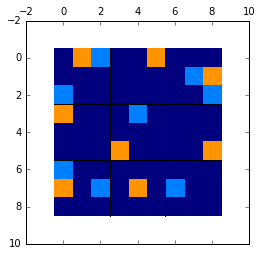

In [5]:
'''Rykky B.'''
NODE = None
def mc_pass(root,game,branch = -1):
    node,moves = select(root,game,puct_constant = 0.75)
    if node.parent is None or node.parent().N[moves[-1]]>branch:
        expand(node,game) 
    result = evaluate(node,game,depth = 0)
    backprop(node,moves,result)

    
import random
board = np.zeros((9,9))
for x in [(0,1),(0,5),(1,8),(3,0),(5,3),(5,8),(7,0),(7,4)]:
    board[x]=1
for o in [(0,2),(1,7),(2,0),(2,8),(3,4),(6,0),(7,2),(7,6)]:
    board[o]=-1
big_board = np.array([[0,0,0],
                      [0,0,0],
                      [0,0,0]])

player = 1
game = Board(board=board,big_board = big_board,player = player)
for move in []:
    game.update_move(move)
log_len = len(game.log)
player = game.player
# root = MC_node(game)

# remove illegal moves on first turn
for move in [(4,4)]:
    root.actions.remove(move)
    
    
tact.fancy_board(game)
t0 = time.clock()


cache = {}
max_size = 1000000
frac = 0.1

count =0
for _ in xrange(10000000):

    count +=1

    while len(game.log) > log_len:
        game.erase_move()


    mc_pass(root,game,5)
#     pn2_pass(root,game,cache,frac = 0.75)
    if _ % 1000 == 0 or root.SL==0 or root.GW==0:
        display.clear_output(wait = True)

        print count
        print 'player {}'.format(player)
        print 'cache size {}'.format(len(cache))
        
        
        print_MC(root)
        print_principal(root)
        if root.SL==0 or root.GW == 0:
            break

tact.fancy_board(game)
print time.clock() - t0

3206001
player 1
cache size 0
(1, 1): 2309670 runs, -0.1916 eval,   29 won,   29 not lost,   96 not won,   96 lost,  1- 1 depth
(1, 0): 782155 runs, -0.1748 eval,   12 won,   12 not lost,   92 not won,   92 lost,  1- 1 depth
(0, 1):  36455 runs, -0.1519 eval,   12 won,   12 not lost,   39 not won,   39 lost,  1- 1 depth
(0, 0):  31072 runs, -0.1473 eval,    9 won,    9 not lost,   39 not won,   39 lost,  1- 1 depth
(2, 0):  26011 runs, -0.1399 eval,    9 won,    9 not lost,   32 not won,   32 lost,  1- 1 depth
(2, 1):  20637 runs, -0.1270 eval,    8 won,    8 not lost,   27 not won,   27 lost,  1- 1 depth
 11 45 46 40 41 44 43 31 03 00 21 73 42 48 56 80 71 35 18 36 22 77


KeyboardInterrupt: 

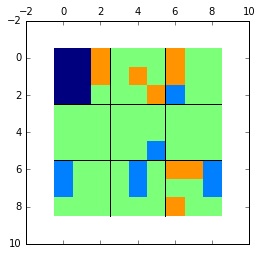

In [6]:
'''ou_uan'''
NODE = None
def mc_pass(root,game,branch = -1):
    node,moves = select(root,game,puct_constant = 0.75)
    if node.parent is None or node.parent().N[moves[-1]]>branch:
        expand(node,game) 
    result = evaluate(node,game,depth = 0)
    backprop(node,moves,result)

    
import random
board = np.zeros((9,9))
for x in [(0,2),(1,2),(1,4),(2,5),(0,6),(1,6),(6,7),(8,6)]:
    board[x]=1
for o in [(6,0),(7,0),(6,4),(7,4),(6,8),(7,8),(5,5),(2,6)]:
    board[o]=-1
big_board = np.array([[0,0,0],
                      [0,0,0],
                      [0,0,0]])

player = 1
game = Board(board=board,big_board = big_board,player = player)
for move in [(6,6)]:
    game.update_move(move)
log_len = len(game.log)
player = game.player
root = MC_node(game)

# remove illegal moves on first turn
# for move in [(6,6)]:
#     root.actions.remove(move)
    
    
tact.fancy_board(game)
t0 = time.clock()


cache = {}
max_size = 1000000
frac = 0.1

count =0
for _ in xrange(10000000):

    count +=1

    while len(game.log) > log_len:
        game.erase_move()


    mc_pass(root,game,5)
#     pn2_pass(root,game,cache,frac = 0.75)
    if _ % 1000 == 0 or root.SL==0 or root.GW==0:
        display.clear_output(wait = True)

        print count
        print 'player {}'.format(player)
        print 'cache size {}'.format(len(cache))
        
        
        print_MC(root)
        print_principal(root)
        if root.SL==0 or root.GW == 0:
            break

tact.fancy_board(game)
print time.clock() - t0

999001
player 1
cache size 0
(5, 1):    438177 runs, +0.0231 eval,   12 won,   12 not lost,   61 not won,   61 lost,  1- 1 depth
(4, 2):    429783 runs, +0.0238 eval,    7 won,    7 not lost,   49 not won,   49 lost,  1- 1 depth
(4, 0):     45534 runs, +0.0382 eval,    7 won,    7 not lost,   40 not won,   40 lost,  1- 1 depth
(3, 1):     39489 runs, +0.0407 eval,    9 won,    9 not lost,   30 not won,   30 lost,  1- 1 depth
(3, 0):     14959 runs, +0.0718 eval,    4 won,    4 not lost,   29 not won,   29 lost,  1- 1 depth
(3, 2):     14178 runs, +0.0746 eval,    6 won,    6 not lost,   16 not won,   16 lost,  1- 1 depth
(5, 2):     13587 runs, +0.0768 eval,    6 won,    6 not lost,   20 not won,   20 lost,  1- 1 depth
(4, 1):      3293 runs, +0.2493 eval,    5 won,    5 not lost,   10 not won,   10 lost,  1- 1 depth
 51 75 56 71 44 53 72 57 73 40 50 81 84 74
501.380709829
         442477262 function calls (442476548 primitive calls) in 501.381 seconds

   Ordered by: internal time

  

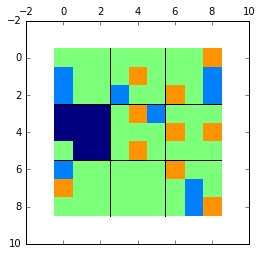

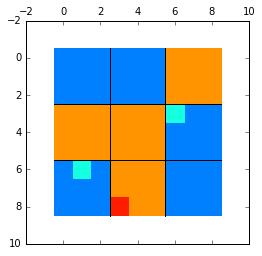

In [5]:
'''Roland S.'''
NODE = None
def mc_pass(root,game,branch = -1):
    node,moves = select(root,game,puct_constant = 0.75)
    if node.parent is None or node.parent().N[moves[-1]]>branch:
        expand(node,game) 
    result = evaluate(node,game,depth = 0)
    backprop(node,moves,result)

    
import random
board = np.zeros((9,9))
for x in [(1,4),(0,8),(2,6),(5,4),(4,6),(4,8),(6,6),(8,8)]:
    board[x]=1
for o in [(1,0),(2,0),(1,8),(2,8),(3,5),(6,0),(7,7),(8,7)]:
    board[o]=-1
big_board = np.array([[0,0,0],
                      [0,0,0],
                      [0,0,0]])

player = 1
game = Board(board=board,big_board = big_board,player = player)
for move in [(3,4),(2,3),(7,0)]:
    game.update_move(move)
log_len = len(game.log)
player = game.player
root = MC_node(game)


tact.fancy_board(game)
t0 = time.clock()


cache = {}
max_size = 1000000
frac = 0.1

def sim():
    count =0

    for _ in xrange(1000000):

        count +=1

        while len(game.log) > log_len:
            game.erase_move()


        mc_pass(root,game,25)
    #     pn2_pass(root,game,cache,frac = 0.75)
        if _ % 1000 == 0 or root.SL==0 or root.GW==0:
            display.clear_output(wait = True)

            print count
            print 'player {}'.format(player)
            print 'cache size {}'.format(len(cache))


            print_MC(root)
            print_principal(root)
            if root.SL==0 or root.GW == 0:
                break

    tact.fancy_board(game)
    print time.clock() - t0
cProfile.run('sim()',sort='tottime')